# HW4 Homework on Credit Risk

Libs and imports

In [83]:
# - устанавливаем необходимые библиотеки
!pip install imbalanced-learn -q
!pip install optbinning -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix, roc_curve
from scipy import stats
import zipfile

DAta loading

In [84]:
# - загрузка данных
import pandas as pd

# читаем файлы напрямую
df_train = pd.read_csv('cs-training.csv')
df_test = pd.read_csv('cs-test.csv')

print(f"Размер тренировочного набора: {df_train.shape}")
print(f"Размер тестового набора: {df_test.shape}")
print("\nПервые строки тренировочных данных:")
df_train.head()

Размер тренировочного набора: (150000, 12)
Размер тестового набора: (101503, 12)

Первые строки тренировочных данных:


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


Initial data inspection

In [85]:
# - удаляем лишний столбец индекса
df_train = df_train.drop('Unnamed: 0', axis=1)
df_test = df_test.drop('Unnamed: 0', axis=1)

# -переименуем столбцы для удобства
df_train.columns = ['target', 'RevolvingUtilization', 'age', 'NumTime30_59DaysPastDue',
                    'DebtRatio', 'MonthlyIncome', 'NumOpenCreditLines',
                    'NumTimes90DaysLate', 'NumRealEstateLoans', 'NumTime60_89DaysPastDue',
                    'NumDependents']

df_test.columns = ['target', 'RevolvingUtilization', 'age', 'NumTime30_59DaysPastDue',
                   'DebtRatio', 'MonthlyIncome', 'NumOpenCreditLines',
                   'NumTimes90DaysLate', 'NumRealEstateLoans', 'NumTime60_89DaysPastDue',
                   'NumDependents']

print("Первые 5 строк данных:")
df_train.head()

Первые 5 строк данных:


,target,RevolvingUtilization,age,NumTime30_59DaysPastDue,DebtRatio,MonthlyIncome,NumOpenCreditLines,NumTimes90DaysLate,NumRealEstateLoans,NumTime60_89DaysPastDue,NumDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


# 1. EXPLORATORY DATA ANALYSIS (EDA) - 20%

Basic stats

In [86]:
# -информация о датасете
print("\n1. ИНФОРМАЦИЯ О ДАТАСЕТЕ:")
print("-"*40)
df_train.info()


1. ИНФОРМАЦИЯ О ДАТАСЕТЕ:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   target                   150000 non-null  int64  
 1   RevolvingUtilization     150000 non-null  float64
 2   age                      150000 non-null  int64  
 3   NumTime30_59DaysPastDue  150000 non-null  int64  
 4   DebtRatio                150000 non-null  float64
 5   MonthlyIncome            120269 non-null  float64
 6   NumOpenCreditLines       150000 non-null  int64  
 7   NumTimes90DaysLate       150000 non-null  int64  
 8   NumRealEstateLoans       150000 non-null  int64  
 9   NumTime60_89DaysPastDue  150000 non-null  int64  
 10  NumDependents            146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


Descriptive stats

In [87]:
desc_stats = df_train.describe().T
desc_stats['missing'] = df_train.isnull().sum()
desc_stats['missing_%'] = (df_train.isnull().sum() / len(df_train) * 100).round(2)
desc_stats

,count,mean,std,min,25%,50%,75%,max,missing,missing_%
target,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0,0,0.00
RevolvingUtilization,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0,0,0.00
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0,0,0.00
NumTime30_59DaysPastDue,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0,0,0.00
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0,0,0.00
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0,29731,19.82
NumOpenCreditLines,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0,0,0.00
NumTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0,0,0.00
NumRealEstateLoans,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0,0,0.00
NumTime60_89DaysPastDue,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0,0,0.00


Target variable analysis

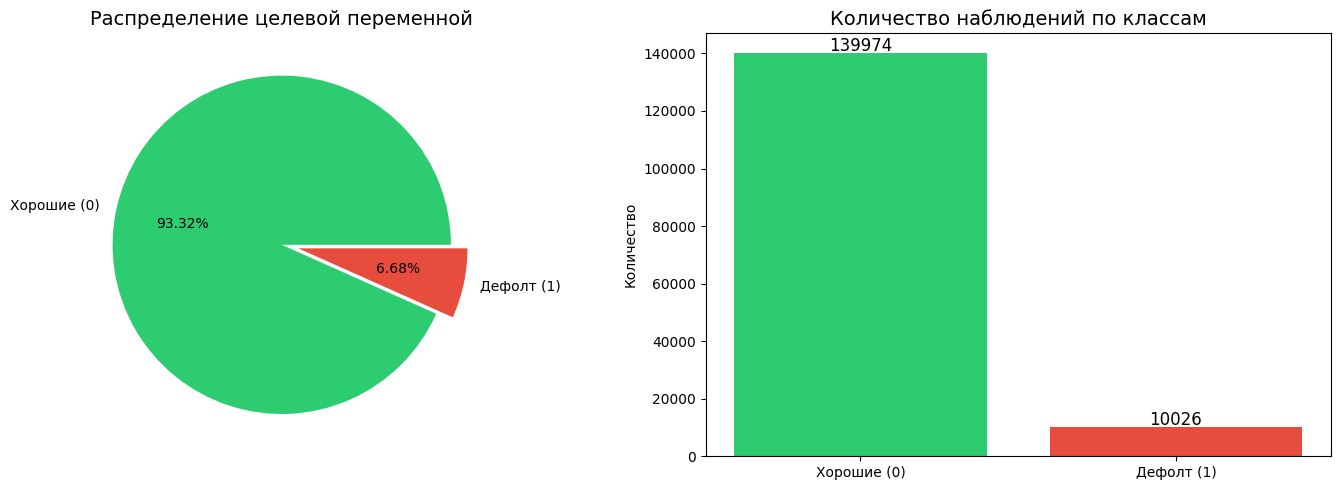


Класс 0 (хорошие заемщики): 139974 (93.32%)
Класс 1 (дефолт): 10026 (6.68%)

Соотношение классов: 1:14.0


In [88]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# - распределение классов
target_counts = df_train['target'].value_counts()
colors = ['#2ecc71', '#e74c3c']

axes[0].pie(target_counts, labels=['Хорошие (0)', 'Дефолт (1)'],
            autopct='%1.2f%%', colors=colors, explode=(0, 0.1))
axes[0].set_title('Распределение целевой переменной', fontsize=14)

# barplot
axes[1].bar(['Хорошие (0)', 'Дефолт (1)'], target_counts.values, color=colors)
axes[1].set_ylabel('Количество')
axes[1].set_title('Количество наблюдений по классам', fontsize=14)
for i, v in enumerate(target_counts.values):
    axes[1].text(i, v + 1000, str(v), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

print(f"\nКласс 0 (хорошие заемщики): {target_counts[0]} ({target_counts[0]/len(df_train)*100:.2f}%)")
print(f"Класс 1 (дефолт): {target_counts[1]} ({target_counts[1]/len(df_train)*100:.2f}%)")
print(f"\nСоотношение классов: 1:{target_counts[0]/target_counts[1]:.1f}")

ВЫВОД: Наблюдается сильный дисбаланс классов (93.3% vs 6.7%)

Необходимо применить методы балансировки при обучении модели

Missing values analysis

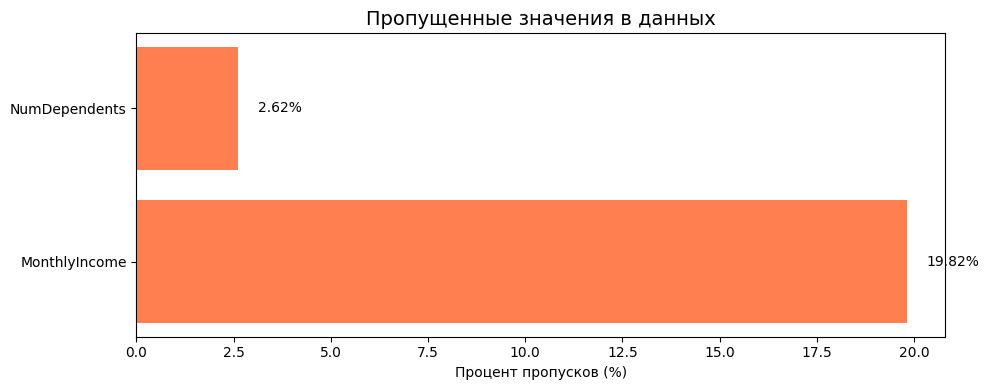

   Переменная  Пропуски  Процент
MonthlyIncome     29731    19.82
NumDependents      3924     2.62


In [89]:
missing_data = pd.DataFrame({
    'Переменная': df_train.columns,
    'Пропуски': df_train.isnull().sum().values,
    'Процент': (df_train.isnull().sum().values / len(df_train) * 100).round(2)
})
missing_data = missing_data[missing_data['Пропуски'] > 0].sort_values('Пропуски', ascending=False)

if len(missing_data) > 0:
    fig, ax = plt.subplots(figsize=(10, 4))
    bars = ax.barh(missing_data['Переменная'], missing_data['Процент'], color='coral')
    ax.set_xlabel('Процент пропусков (%)')
    ax.set_title('Пропущенные значения в данных', fontsize=14)
    for bar, val in zip(bars, missing_data['Процент']):
        ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val}%', va='center')
    plt.tight_layout()
    plt.show()
    print(missing_data.to_string(index=False))
else:
    print("Пропущенных значений нет!")

ВЫВОД: MonthlyIncome имеет 19.8% пропусков, NumDependents - 2.6%

Необходимо заполнить пропуски медианой или другим методом

Distribution of all variables

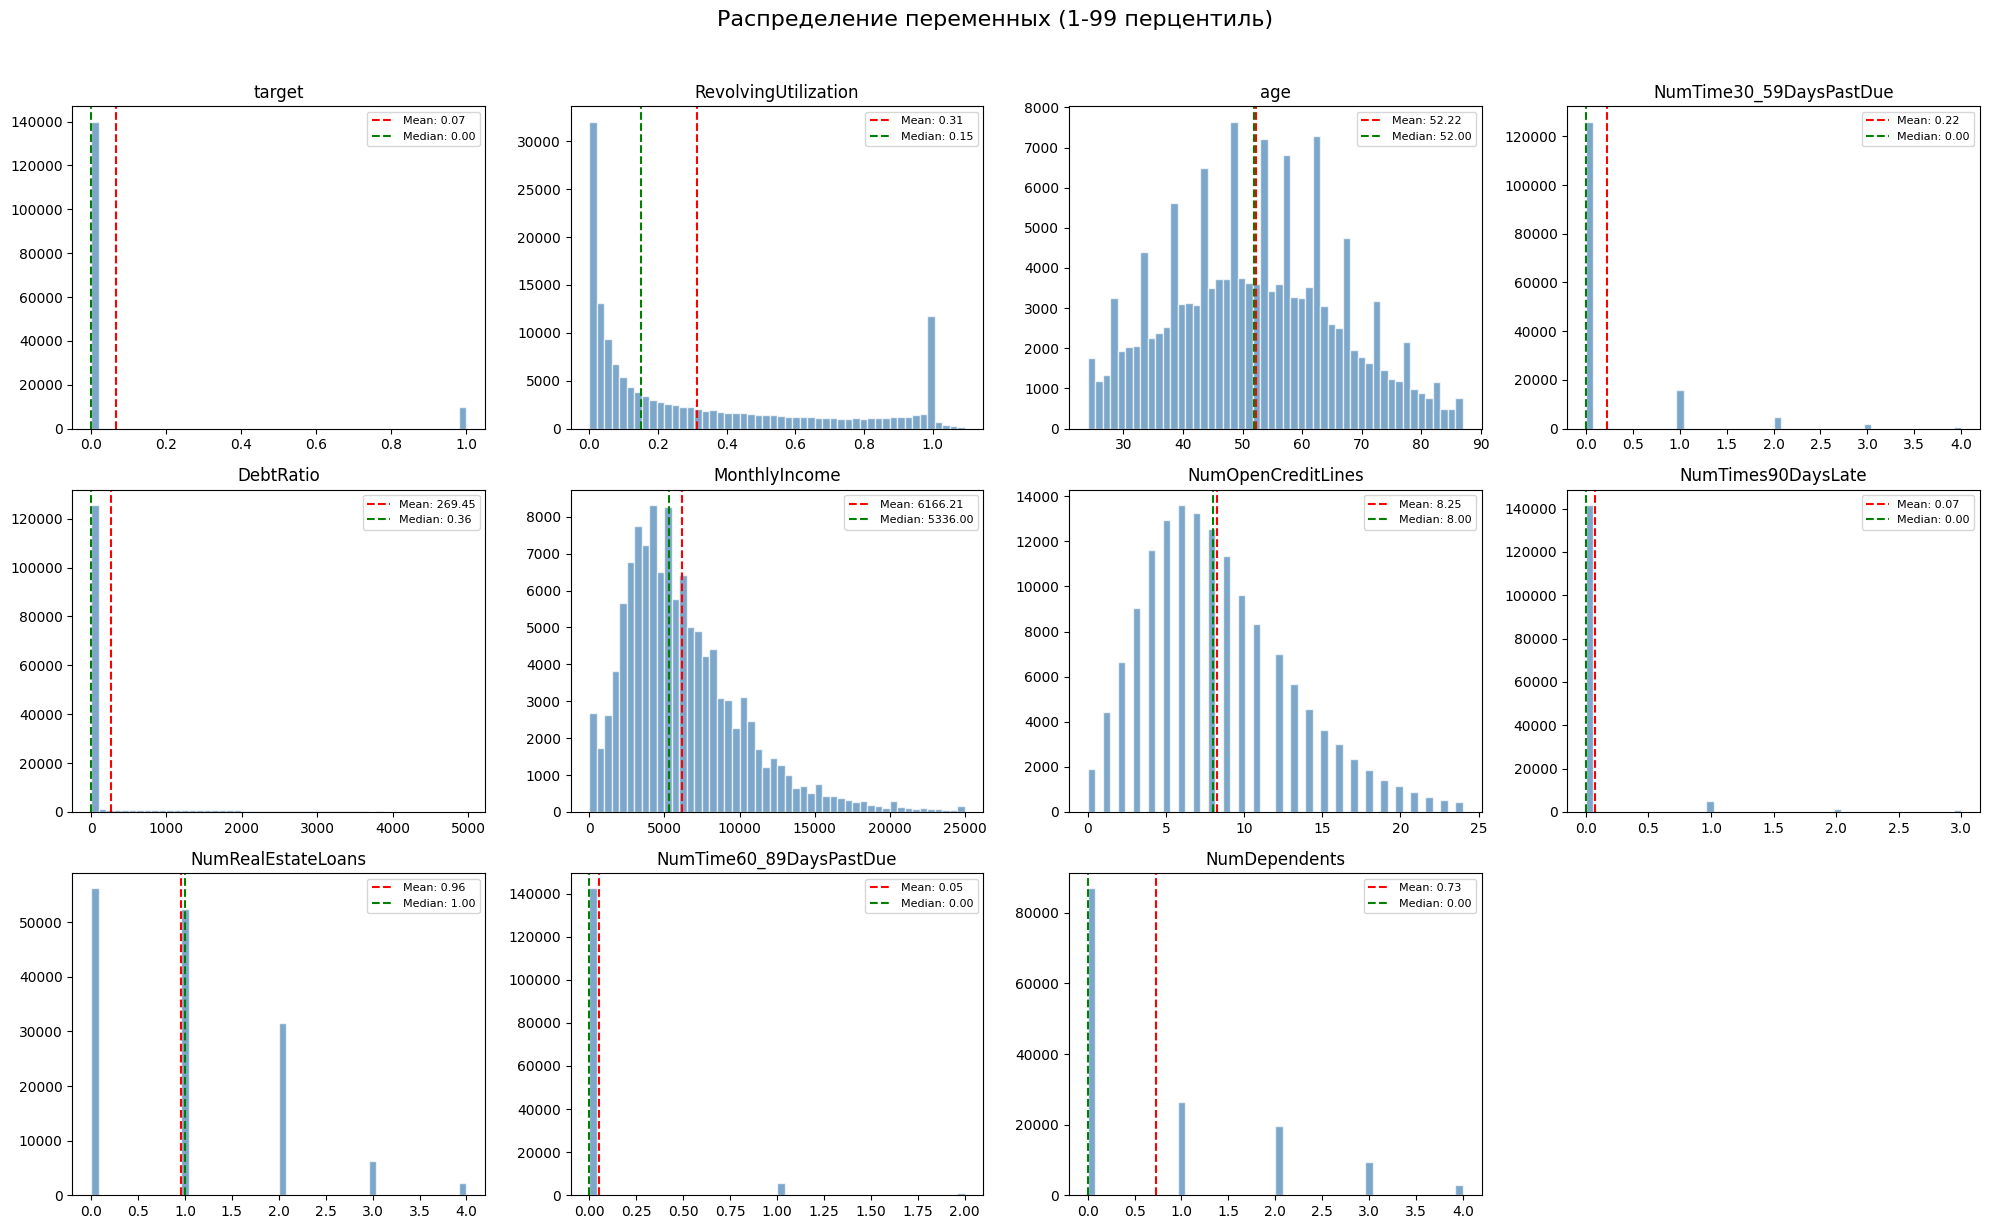

In [90]:
fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, col in enumerate(df_train.columns):
    ax = axes[idx]

    # - убираем выбросы для визуализации
    data = df_train[col].dropna()
    q1, q99 = data.quantile([0.01, 0.99])
    data_filtered = data[(data >= q1) & (data <= q99)]

    ax.hist(data_filtered, bins=50, color='steelblue', edgecolor='white', alpha=0.7)
    ax.axvline(data_filtered.mean(), color='red', linestyle='--', label=f'Mean: {data_filtered.mean():.2f}')
    ax.axvline(data_filtered.median(), color='green', linestyle='--', label=f'Median: {data_filtered.median():.2f}')
    ax.set_title(f'{col}', fontsize=12)
    ax.legend(fontsize=8)

# - удаляем лишние графики
for idx in range(len(df_train.columns), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Распределение переменных (1-99 перцентиль)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

**Вывод**
- RevolvingUtilization — распределение сильно скошено вправо, большая часть значений сосредоточена около 0, также присутствуют аномальные значения > 1, которые требуют дополнительной обработки
- Age — нет выраженной асимметрии, среднее и медиана около 52 лет, распределение не является строго нормальным
- DebtRatio — крайне правосторонне скошенное распределение с экстремальными выбросами, медиана значительно меньше среднего, признак чувствителен к аномалиям
- Признаки с количеством просрочек (NumTime*) — большая часть значений равна 0, ненулевые значения встречаются редко

Outlier analysis with boxplots

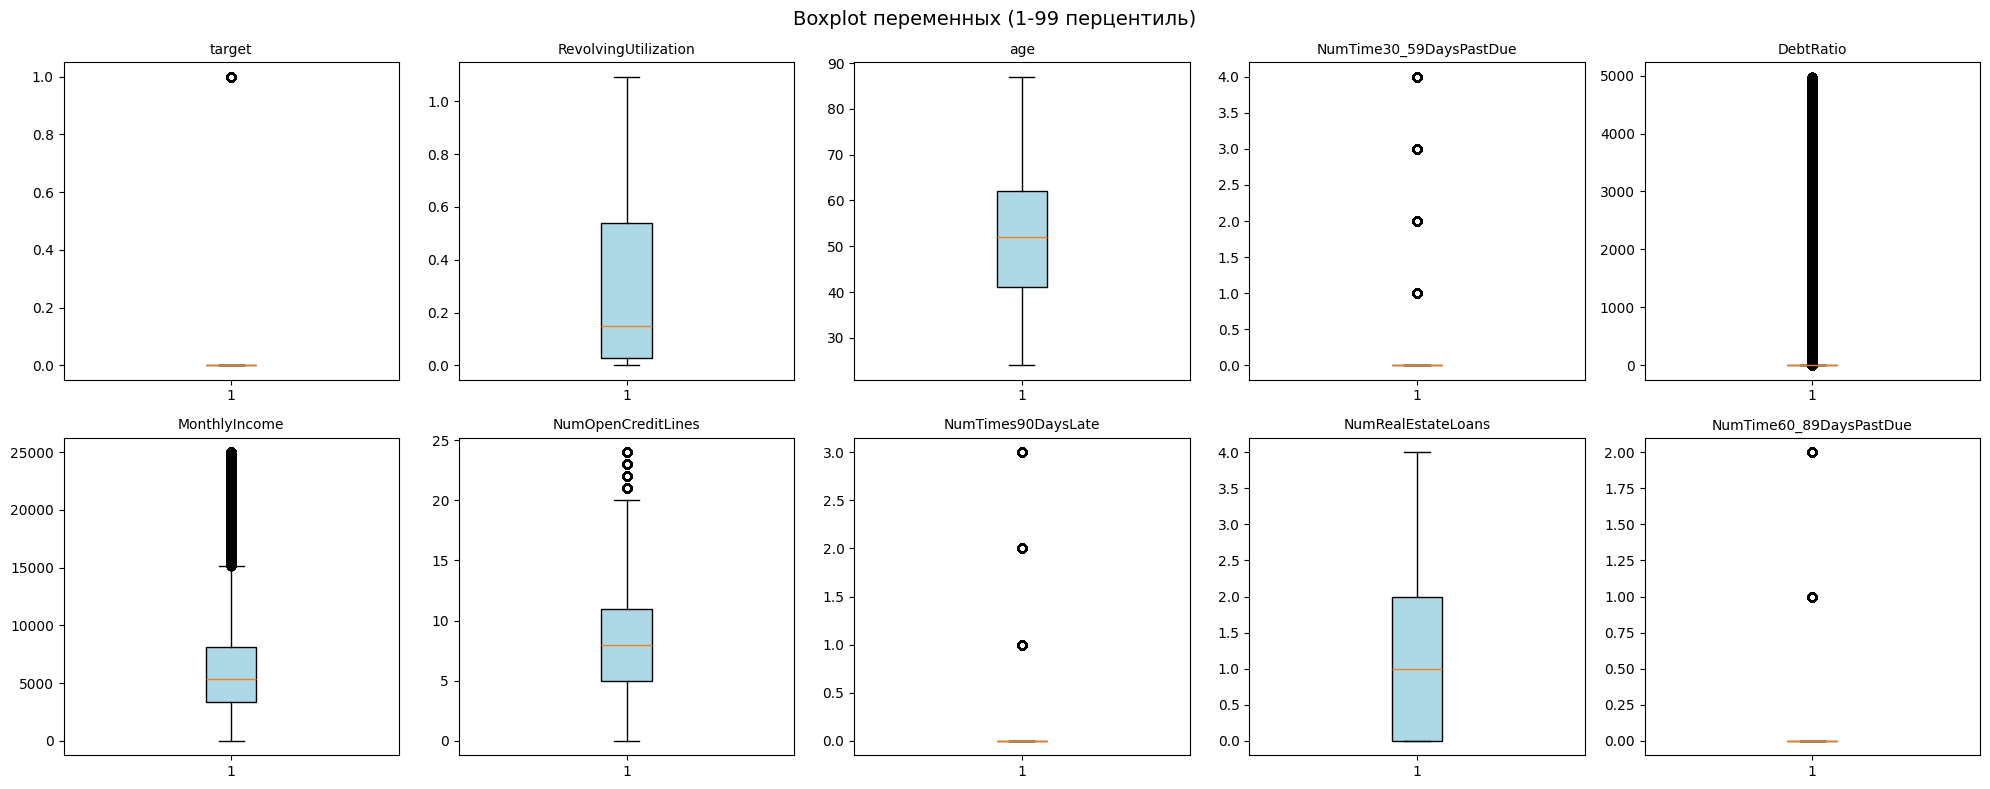


Выбросы по правилу 3-х сигм:
  RevolvingUtilization: 191 выбросов (0.13%)
  age: 46 выбросов (0.03%)
  NumTime30_59DaysPastDue: 270 выбросов (0.18%)
  DebtRatio: 659 выбросов (0.44%)
  MonthlyIncome: 321 выбросов (0.27%)
  NumOpenCreditLines: 1898 выбросов (1.27%)
  NumTimes90DaysLate: 278 выбросов (0.19%)
  NumRealEstateLoans: 1482 выбросов (0.99%)
  NumTime60_89DaysPastDue: 269 выбросов (0.18%)
  NumDependents: 991 выбросов (0.68%)


In [91]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, col in enumerate(df_train.columns):
    if idx < len(axes):
        ax = axes[idx]
        # - фильтруем данные для лучшей визуализации
        data = df_train[col].dropna()
        q1, q99 = data.quantile([0.01, 0.99])
        data_filtered = data[(data >= q1) & (data <= q99)]

        box = ax.boxplot(data_filtered, patch_artist=True)
        box['boxes'][0].set_facecolor('lightblue')
        ax.set_title(col, fontsize=10)

plt.suptitle('Boxplot переменных (1-99 перцентиль)', fontsize=14)
plt.tight_layout()
plt.show()

# - выявление выбросов
print("\nВыбросы по правилу 3-х сигм:")
for col in df_train.columns:
    if col != 'target':
        data = df_train[col].dropna()
        mean, std = data.mean(), data.std()
        outliers = ((data < mean - 3*std) | (data > mean + 3*std)).sum()
        if outliers > 0:
            print(f"  {col}: {outliers} выбросов ({outliers/len(data)*100:.2f}%)")

Correlation analysis

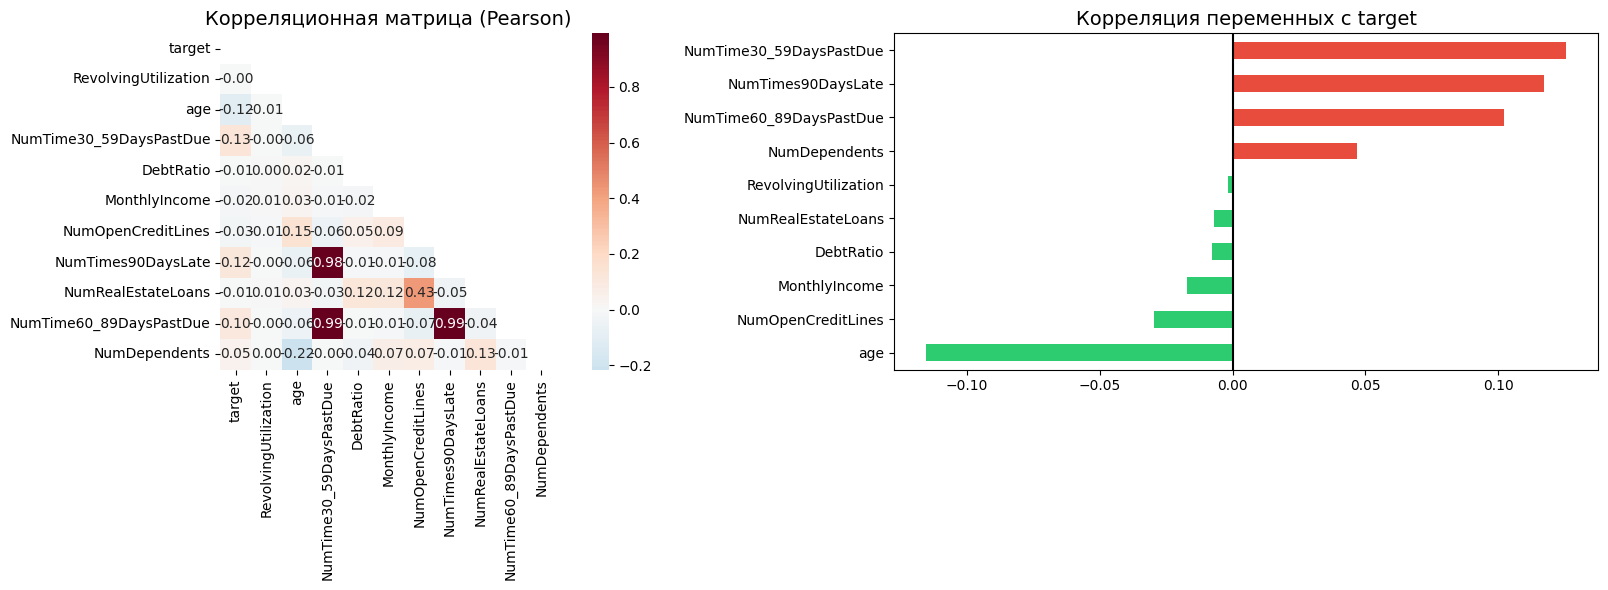


Корреляция с целевой переменной (target):
NumTime30_59DaysPastDue    0.125587
NumTimes90DaysLate         0.117175
NumTime60_89DaysPastDue    0.102261
NumDependents              0.046869
RevolvingUtilization      -0.001802
NumRealEstateLoans        -0.007038
DebtRatio                 -0.007602
MonthlyIncome             -0.017151
NumOpenCreditLines        -0.029669
age                       -0.115386


In [92]:
# - заполним пропуски - для расчета корреляции
df_corr = df_train.copy()
df_corr['MonthlyIncome'].fillna(df_corr['MonthlyIncome'].median(), inplace=True)
df_corr['NumDependents'].fillna(df_corr['NumDependents'].median(), inplace=True)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# - корреляционная матрица
corr_matrix = df_corr.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, ax=axes[0], square=True)
axes[0].set_title('Корреляционная матрица (Pearson)', fontsize=14)

# - корреляция с целевой переменной
target_corr = corr_matrix['target'].drop('target').sort_values()
colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in target_corr]
target_corr.plot(kind='barh', ax=axes[1], color=colors)
axes[1].set_title('Корреляция переменных с target', fontsize=14)
axes[1].axvline(x=0, color='black', linestyle='-')

plt.tight_layout()
plt.show()

print("\nКорреляция с целевой переменной (target):")
print(target_corr.sort_values(ascending=False).to_string())

**Вывод**
- Наибольшую положительную корреляцию с целевой переменной имеют признаки, которые связаны с просрочками:

NumTime30_59DaysPastDue (~0.13)

NumTimes90DaysLate (~0.12)

NumTime60_89DaysPastDue (~0.10)

Однако все корреляции остаются слабыми

- Признаки, которые отражают количество просрочек, очень сильно коррелируют
  между собой (коэффициенты примерно 0.98–0.99), это указывает на выраженную
  мультиколлинеарность (в данных есть признаки, которые очень сильно похожи друг на друга, поэтому модель получает пвторяющуюся информацию)

- Возраст (age) имеет наиболее заметную отрицательную корреляцию с дефолтом
  (примерно -0.12): более молодые заемщики чаще допускают дефолт

- Остальные признаки (RevolvingUtilization, DebtRatio, MonthlyIncome,
  NumOpenCreditLines) имеют близкую к нулю линейную корреляцию с таргетом

Analysis of features with respect to the target variable

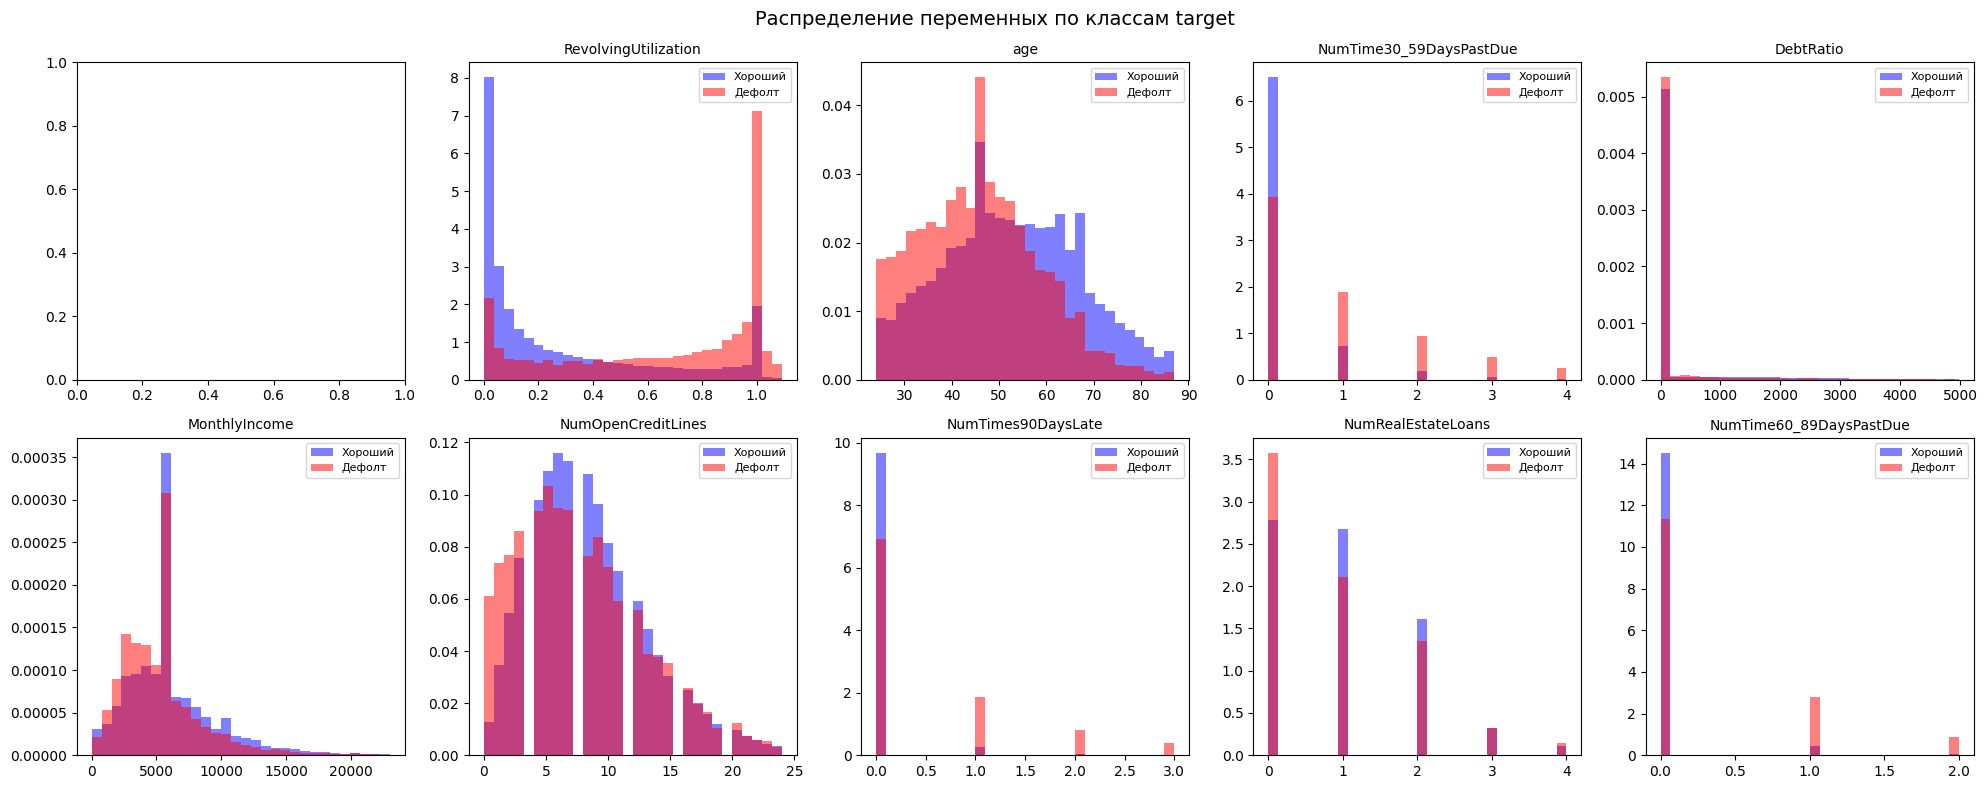

In [93]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, col in enumerate(df_train.columns):
    if col != 'target' and idx < len(axes):
        ax = axes[idx]

        # Фильтрация выбросов для визуализации
        data = df_corr.copy()
        q1, q99 = data[col].quantile([0.01, 0.99])
        data_filtered = data[(data[col] >= q1) & (data[col] <= q99)]

        for target_val in [0, 1]:
            subset = data_filtered[data_filtered['target'] == target_val][col]
            label = 'Дефолт' if target_val == 1 else 'Хороший'
            color = 'red' if target_val == 1 else 'blue'
            ax.hist(subset, bins=30, alpha=0.5, label=label, color=color, density=True)

        ax.set_title(col, fontsize=10)
        ax.legend(fontsize=8)

plt.suptitle('Распределение переменных по классам target', fontsize=14)
plt.tight_layout()
plt.show()

**Вывод**
- У дефолтных клиентов наблюдается более высокий RevolvingUtilization - распределение смещено в сторону больших значений (по сравнению с недефолтными)
- Признаки, которые связаны с просрочками платежей наиболее явно различают классы - дефолтные клиенты значительно чаще имеют ненулевые значения просрочек
- Возраст дефолтных клиентов в среднем ниже: распределение смещено в сторону более молодых заемщиков, но классы существенно перекрываются
- Дефолтные клиенты в среднем имеют более низкий MonthlyIncome, но различие выражено умеренно и не является разделяющим признаком само по себ

Statistical tests

In [94]:
print("\nСравнение средних значений между классами:")

print(f"{'Переменная':<35} {'Mean(0)':<12} {'Mean(1)':<12} {'p-value':<12} {'Значимость'}")


for col in df_train.columns:
    if col != 'target':
        group0 = df_corr[df_corr['target'] == 0][col].dropna()
        group1 = df_corr[df_corr['target'] == 1][col].dropna()

        stat, pvalue = stats.mannwhitneyu(group0, group1, alternative='two-sided')
        significance = "***" if pvalue < 0.001 else "**" if pvalue < 0.01 else "*" if pvalue < 0.05 else "ns"

        print(f"{col:<35} {group0.mean():<12.2f} {group1.mean():<12.2f} {pvalue:<12.4f} {significance}")

print("\n*** p<0.001, ** p<0.01, * p<0.05, ns - не значимо")


Сравнение средних значений между классами:
Переменная                          Mean(0)      Mean(1)      p-value      Значимость
RevolvingUtilization                6.17         4.37         0.0000       ***
age                                 52.75        45.93        0.0000       ***
NumTime30_59DaysPastDue             0.28         2.39         0.0000       ***
DebtRatio                           357.15       295.12       0.0000       ***
MonthlyIncome                       6477.62      5592.40      0.0000       ***
NumOpenCreditLines                  8.49         7.88         0.0000       ***
NumTimes90DaysLate                  0.14         2.09         0.0000       ***
NumRealEstateLoans                  1.02         0.99         0.0000       ***
NumTime60_89DaysPastDue             0.13         1.83         0.0000       ***
NumDependents                       0.72         0.93         0.0000       ***

*** p<0.001, ** p<0.01, * p<0.05, ns - не значимо


# EDA выводы:

1. В данных присутствует выраженный дисбаланс классов
   (около 93% — недефолтные клиенты, 7% — дефолтные)
2. Обнаружены пропущенные значения в MonthlyIncome (примерно20%)
   и NumDependents (примерно3%), которые требуют обработки
3. Для признаков RevolvingUtilization и DebtRatio выявлены
   существенные выбросы и асимметричные распределения
4. Все численные признаки демонстрируют статистически значимые
   различия распределений между классами (p < 0.001), но
   величина эффекта различается
5. Признаки, которые связаны с просрочками платежей, являются наиболее
   информативными и лучше всего различают дефолтных и
   недефолтных клиентов


# 2. СОЗДАНИЕ ДОПОЛНИТЕЛЬНЫХ ПЕРЕМЕННЫХ - 10%

In [95]:
def create_features(df):
    """создание доп переменных"""
    df = df.copy()

    # 1 - общее количество просрочек
    df['TotalPastDue'] = (df['NumTime30_59DaysPastDue'] +
                          df['NumTime60_89DaysPastDue'] +
                          df['NumTimes90DaysLate'])

    # 2 - флаг наличия любой просрочки
    df['HasAnyPastDue'] = (df['TotalPastDue'] > 0).astype(int)

    # 3 - флаг серьезной просрочки (90+ дней)
    df['HasSeriousPastDue'] = (df['NumTimes90DaysLate'] > 0).astype(int)

    # 4 - возрастные группы
    df['AgeGroup'] = pd.cut(df['age'],
                            bins=[0, 25, 35, 45, 55, 65, 100],
                            labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])

    # 5 - доход на члена семьи
    df['NumDependents'] = df['NumDependents'].fillna(0)
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())
    df['IncomePerPerson'] = df['MonthlyIncome'] / (df['NumDependents'] + 1)

    # 6 - соотношение кредитных линий к недвижимости
    df['CreditToRealEstate'] = df['NumOpenCreditLines'] / (df['NumRealEstateLoans'] + 1)

    # 7 - флаг высокой долговой нагрузки
    df['HighDebtRatio'] = (df['DebtRatio'] > 0.43).astype(int)  # правило 43%

    # 8 - флаг высокой утилизации кредита
    df['HighUtilization'] = (df['RevolvingUtilization'] > 0.7).astype(int)

    # 9 - взаимодействие: возраст * доход
    df['AgeIncomeInteraction'] = df['age'] * np.log1p(df['MonthlyIncome'])

    # 10 - взаимодействие: утилизация * долговая нагрузка
    df['UtilizationDebtInteraction'] = df['RevolvingUtilization'] * df['DebtRatio']

    # 11 - логарифм дохода
    df['LogIncome'] = np.log1p(df['MonthlyIncome'])

    # 12 - флаг молодого заемщика (высокий риск)
    df['YoungBorrower'] = (df['age'] < 30).astype(int)

    return df

# применим к обоим датасетам
df_train_fe = create_features(df_train)
df_test_fe = create_features(df_test)

# показываем новые переменные
new_features = ['TotalPastDue', 'HasAnyPastDue', 'HasSeriousPastDue', 'AgeGroup',
                'IncomePerPerson', 'CreditToRealEstate', 'HighDebtRatio',
                'HighUtilization', 'AgeIncomeInteraction', 'UtilizationDebtInteraction',
                'LogIncome', 'YoungBorrower']

print(f"\nСоздано {len(new_features)} новых переменных:")
for i, feat in enumerate(new_features, 1):
    print(f"  {i}. {feat}")

print("\nПримеры новых переменных:")
df_train_fe[new_features[:8]].head(10)


Создано 12 новых переменных:
  1. TotalPastDue
  2. HasAnyPastDue
  3. HasSeriousPastDue
  4. AgeGroup
  5. IncomePerPerson
  6. CreditToRealEstate
  7. HighDebtRatio
  8. HighUtilization
  9. AgeIncomeInteraction
  10. UtilizationDebtInteraction
  11. LogIncome
  12. YoungBorrower

Примеры новых переменных:


,TotalPastDue,HasAnyPastDue,HasSeriousPastDue,AgeGroup,IncomePerPerson,CreditToRealEstate,HighDebtRatio,HighUtilization
0,2,1,0,36-45,3040.000000,1.857143,1,1
1,0,0,0,36-45,1300.000000,4.000000,0,1
2,2,1,1,36-45,3042.000000,2.000000,0,0
3,0,0,0,26-35,3300.000000,5.000000,0,0
4,1,1,0,46-55,63588.000000,3.500000,0,1
5,0,0,0,65+,1750.000000,1.500000,0,0
6,0,0,0,56-65,5400.000000,2.000000,1,0
7,0,0,0,36-45,3500.000000,8.000000,0,1
8,0,0,0,26-35,5400.000000,2.000000,1,0
9,0,0,0,56-65,7894.666667,1.800000,1,0


Evaluation of engineered features

  TotalPastDue: 0.1155
  HasAnyPastDue: 0.3144
  HasSeriousPastDue: 0.3396
  AgeGroup: -0.1144
  IncomePerPerson: -0.0266
  CreditToRealEstate: -0.0206
  HighDebtRatio: 0.0348
  HighUtilization: 0.2639
  AgeIncomeInteraction: -0.1088
  UtilizationDebtInteraction: 0.0071
  LogIncome: -0.0176
  YoungBorrower: 0.0505


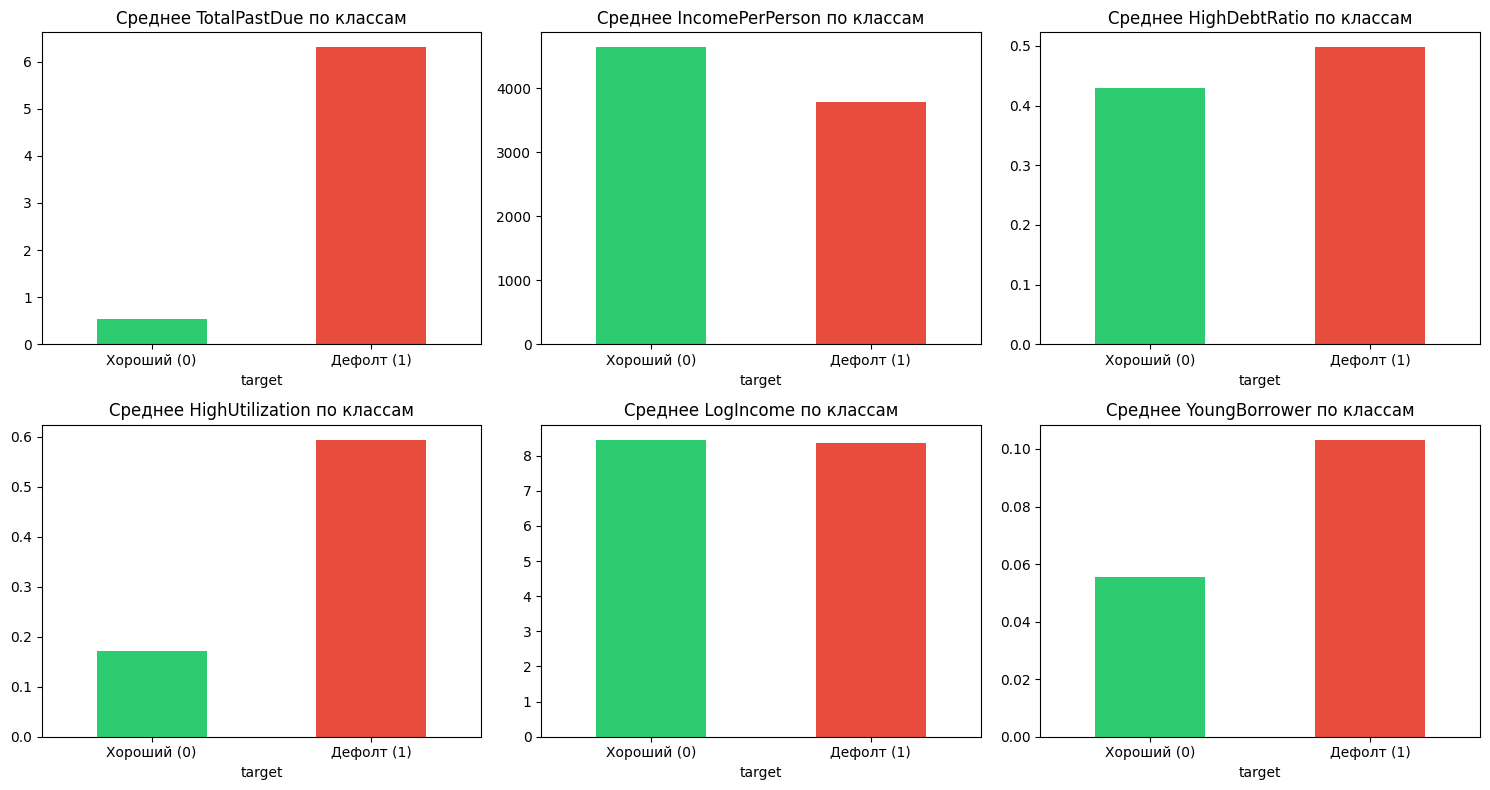

In [96]:
# конвертация AgeGroup в числовой формат - для корреляции
df_temp = df_train_fe.copy()
df_temp['AgeGroup'] = df_temp['AgeGroup'].cat.codes

numeric_new_features = [f for f in new_features if f in df_temp.select_dtypes(include=[np.number]).columns]

for feat in numeric_new_features:
    corr = df_temp[feat].corr(df_temp['target'])
    print(f"  {feat}: {corr:.4f}")

# визуализация
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

plot_features = ['TotalPastDue', 'IncomePerPerson', 'HighDebtRatio',
                 'HighUtilization', 'LogIncome', 'YoungBorrower']

for idx, feat in enumerate(plot_features):
    ax = axes[idx]
    df_temp.groupby('target')[feat].mean().plot(kind='bar', ax=ax, color=['#2ecc71', '#e74c3c'])
    ax.set_title(f'Среднее {feat} по классам')
    ax.set_xticklabels(['Хороший (0)', 'Дефолт (1)'], rotation=0)

plt.tight_layout()
plt.show()

**Вывод**
- Часть созданных признаков значительно улучшают различие между классами,
  самыми информативными являются бинарные индикаторы просрочек
  (HasAnyPastDue, HasSeriousPastDue), а также HighUtilization и TotalPastDue
- Возрастные признаки (AgeGroup, YoungBorrower) показывают умеренную связь
  с целевой переменной и подтверждают повышенный риск среди молодых заемщиков
- Признаки, которые связанны с доходом и взаимодействиями, имеют слабую линейную
  корреляцию с target и, скорее всего, обладают ограниченной самостоятельной
  предсказательной способностью
- В целом, новые признаки, связанные с просрочками и кредитной нагрузкой -  наиболее перспективыне для использования в модели


# 3. ПОСТРОЕНИЕ МОДЕЛИ (WoE + Logistic Regression) - 50%

In [97]:
# - готовим данные и заполняем пропуски
df_model = df_train_fe.copy()
df_model['MonthlyIncome'].fillna(df_model['MonthlyIncome'].median(), inplace=True)
df_model['NumDependents'].fillna(0, inplace=True)

# - убираем категориальную переменную для модели
df_model = df_model.drop('AgeGroup', axis=1)

# - обработка выбросов
df_model['RevolvingUtilization'] = df_model['RevolvingUtilization'].clip(0, 2)
df_model['DebtRatio'] = df_model['DebtRatio'].clip(0, df_model['DebtRatio'].quantile(0.99))

# - разделение на признаки и целевую переменную
X = df_model.drop('target', axis=1)
y = df_model['target']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                      random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение target в train: {y_train.value_counts(normalize=True).round(4).to_dict()}")
print(f"Распределение target в test: {y_test.value_counts(normalize=True).round(4).to_dict()}")

Размер обучающей выборки: (105000, 21)
Размер тестовой выборки: (45000, 21)

Распределение target в train: {0: 0.9332, 1: 0.0668}
Распределение target в test: {0: 0.9332, 1: 0.0668}


Functions for WoE and IV calculation

In [98]:
def calculate_woe_iv(df, feature, target, bins=20):
    """
    расчет WoE и IV для переменной
    """
    # - создается копия данных
    data = pd.DataFrame({feature: df[feature], target: df[target]})

    # - биннинг для непрерывных переменных
    if data[feature].nunique() > bins:
        data['bin'] = pd.qcut(data[feature], q=bins, duplicates='drop')
    else:
        data['bin'] = data[feature]

    # - подсчет статистик по бинам
    grouped = data.groupby('bin', observed=True).agg({
        target: ['count', 'sum']
    }).reset_index()
    grouped.columns = ['bin', 'total', 'bad']
    grouped['good'] = grouped['total'] - grouped['bad']

    # - расчет долей
    total_good = grouped['good'].sum()
    total_bad = grouped['bad'].sum()

    grouped['dist_good'] = grouped['good'] / total_good
    grouped['dist_bad'] = grouped['bad'] / total_bad

    # - защита от деления на ноль
    grouped['dist_good'] = grouped['dist_good'].replace(0, 0.0001)
    grouped['dist_bad'] = grouped['dist_bad'].replace(0, 0.0001)

    # - расчет WoE и IV
    grouped['woe'] = np.log(grouped['dist_good'] / grouped['dist_bad'])
    grouped['iv'] = (grouped['dist_good'] - grouped['dist_bad']) * grouped['woe']

    iv_total = grouped['iv'].sum()

    return grouped, iv_total


def fine_classing(df, feature, target, n_bins=20):
    """
    Step 1: Fine Classing - разбиение на большое количество бинов
    """
    return calculate_woe_iv(df, feature, target, bins=n_bins)


def coarse_classing(df, feature, target, n_bins=5):
    """
    Step 2: Coarse Classing - укрупнение интервалов до 5-10 бинов
    """
    return calculate_woe_iv(df, feature, target, bins=n_bins)


def apply_woe_transformation(df, feature, woe_table):
    """
    Применение WoE трансформации к данным
    """
    # - создается маппинг
    df_result = df.copy()

    # - если бины категориальные (интервалы)
    if hasattr(woe_table['bin'].iloc[0], 'left'):
        # - создается функция для маппинга
        def map_to_woe(value):
            for _, row in woe_table.iterrows():
                if pd.isna(value):
                    return 0
                if row['bin'].left <= value <= row['bin'].right:
                    return row['woe']
            return 0

        df_result[f'{feature}_woe'] = df[feature].apply(map_to_woe)
    else:
        # - для дискретных переменных
        woe_dict = dict(zip(woe_table['bin'], woe_table['woe']))
        df_result[f'{feature}_woe'] = df[feature].map(woe_dict).fillna(0)

    return df_result

Fine Classing (Step 1)


Fine Classing Results (20 бинов):
------------------------------------------------------------

RevolvingUtilization:
  IV = 1.1596
  Количество бинов: 19

age:
  IV = 0.2454
  Количество бинов: 20

DebtRatio:
  IV = 0.0820
  Количество бинов: 20

MonthlyIncome:
  IV = 0.0799
  Количество бинов: 17

NumTime30_59DaysPastDue:
  IV = 0.7416
  Количество бинов: 16

NumTimes90DaysLate:
  IV = 0.8947
  Количество бинов: 19

NumOpenCreditLines:
  IV = 0.0864
  Количество бинов: 15

NumRealEstateLoans:
  IV = 0.0179
  Количество бинов: 4

TotalPastDue:
  IV = 1.1019
  Количество бинов: 3

IncomePerPerson:
  IV = 0.0979
  Количество бинов: 18


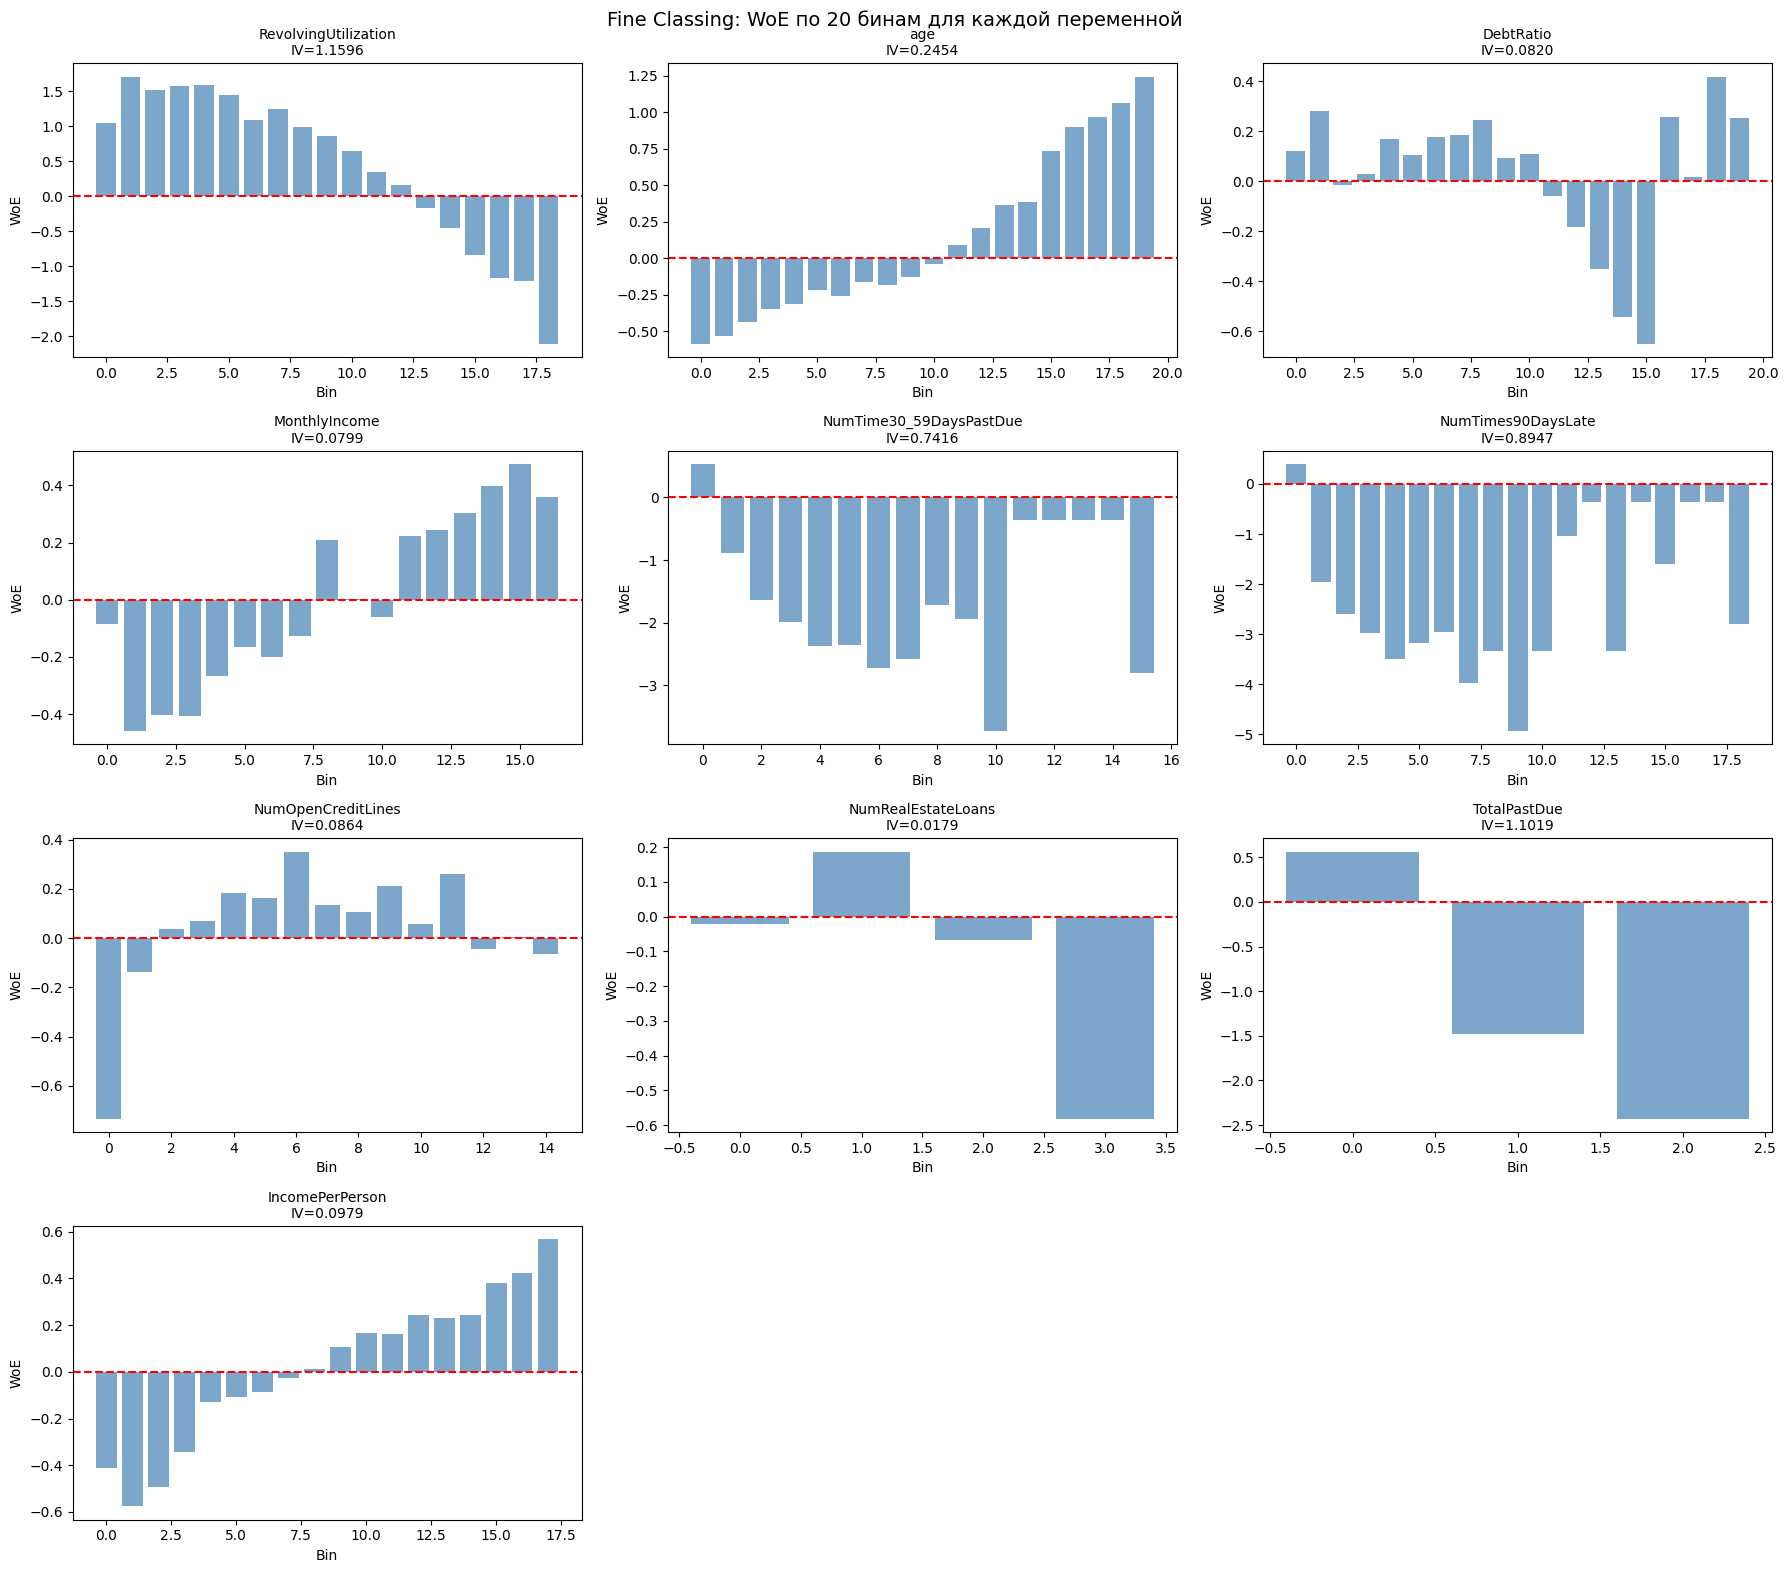

In [99]:
# - выбираем ключевые переменные для WoE
key_features = ['RevolvingUtilization', 'age', 'DebtRatio', 'MonthlyIncome',
                'NumTime30_59DaysPastDue', 'NumTimes90DaysLate', 'NumOpenCreditLines',
                'NumRealEstateLoans', 'TotalPastDue', 'IncomePerPerson']

# Fine Classing для каждой переменной
fine_class_results = {}
iv_values = {}

print("\nFine Classing Results (20 бинов):")
print("-"*60)

fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, feature in enumerate(key_features):
    fine_result, iv = fine_classing(X_train.assign(target=y_train), feature, 'target', n_bins=20)
    fine_class_results[feature] = fine_result
    iv_values[feature] = iv

    print(f"\n{feature}:")
    print(f"  IV = {iv:.4f}")
    print(f"  Количество бинов: {len(fine_result)}")

    # визуализация
    if idx < len(axes):
        ax = axes[idx]
        # преобразуем bin в строку для визуализации
        x_labels = range(len(fine_result))
        ax.bar(x_labels, fine_result['woe'], color='steelblue', alpha=0.7)
        ax.axhline(y=0, color='red', linestyle='--')
        ax.set_title(f'{feature}\nIV={iv:.4f}', fontsize=10)
        ax.set_xlabel('Bin')
        ax.set_ylabel('WoE')

# удаляем лишние графики
for idx in range(len(key_features), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Fine Classing: WoE по 20 бинам для каждой переменной', fontsize=14)
plt.tight_layout()
plt.show()

Interpretation of IV (Information Value)

IV values table

Переменная                             IV     Предсказательная сила
RevolvingUtilization               1.1596     Подозрительно высокая
TotalPastDue                       1.1019     Подозрительно высокая
NumTimes90DaysLate                 0.8947     Подозрительно высокая
NumTime30_59DaysPastDue            0.7416     Подозрительно высокая
age                                0.2454                   Средняя
IncomePerPerson                    0.0979                    Слабая
NumOpenCreditLines                 0.0864                    Слабая
DebtRatio                          0.0820                    Слабая
MonthlyIncome                      0.0799                    Слабая
NumRealEstateLoans                 0.0179               Не подходит


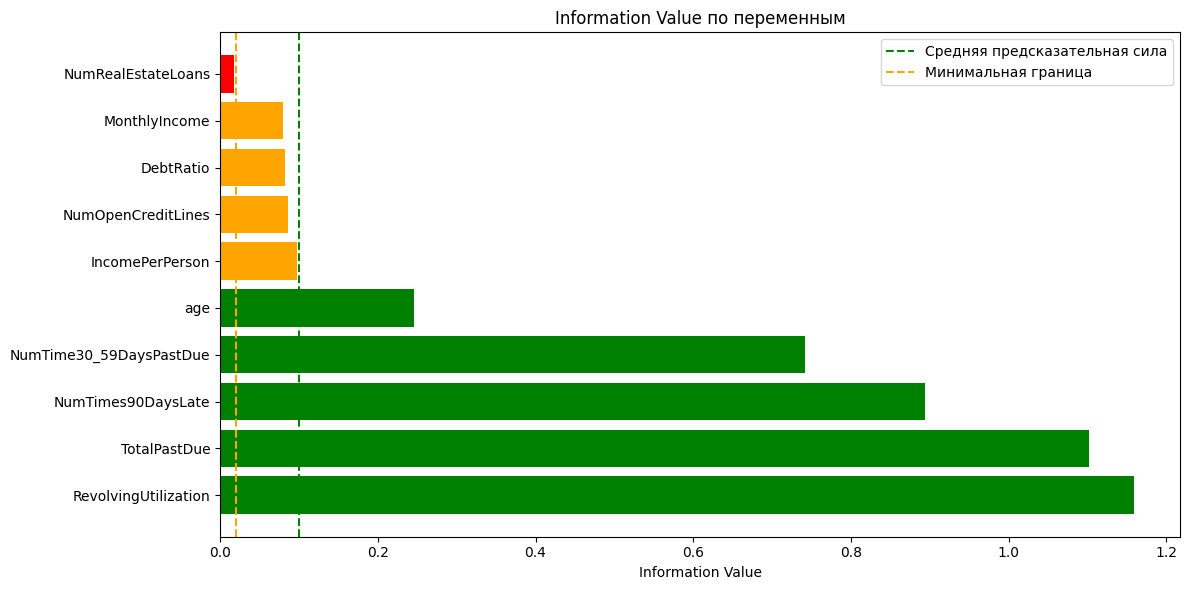

In [100]:
print(f"{'Переменная':<30} {'IV':>10} {'Предсказательная сила':>25}")

iv_df = pd.DataFrame({
    'Feature': iv_values.keys(),
    'IV': iv_values.values()
}).sort_values('IV', ascending=False)

for _, row in iv_df.iterrows():
    if row['IV'] < 0.02:
        strength = 'Не подходит'
    elif row['IV'] < 0.1:
        strength = 'Слабая'
    elif row['IV'] < 0.3:
        strength = 'Средняя'
    elif row['IV'] < 0.5:
        strength = 'Сильная'
    else:
        strength = 'Подозрительно высокая'
    print(f"{row['Feature']:<30} {row['IV']:>10.4f} {strength:>25}")

# визуализация IV
plt.figure(figsize=(12, 6))
colors = ['green' if x >= 0.1 else 'orange' if x >= 0.02 else 'red' for x in iv_df['IV']]
plt.barh(iv_df['Feature'], iv_df['IV'], color=colors)
plt.axvline(x=0.1, color='green', linestyle='--', label='Средняя предсказательная сила')
plt.axvline(x=0.02, color='orange', linestyle='--', label='Минимальная граница')
plt.xlabel('Information Value')
plt.title('Information Value по переменным')
plt.legend()
plt.tight_layout()
plt.show()

 Coarse Classing (Step 2)


Выбраны переменные с IV >= 0.02: ['RevolvingUtilization', 'TotalPastDue', 'NumTimes90DaysLate', 'NumTime30_59DaysPastDue', 'age', 'IncomePerPerson', 'NumOpenCreditLines', 'DebtRatio', 'MonthlyIncome']

RevolvingUtilization: 6 бинов, IV = 1.0767

TotalPastDue: 2 бинов, IV = 1.0459

NumTimes90DaysLate: 1 бинов, IV = 0.0000

NumTime30_59DaysPastDue: 1 бинов, IV = 0.0000

age: 6 бинов, IV = 0.2367

IncomePerPerson: 6 бинов, IV = 0.0937

NumOpenCreditLines: 6 бинов, IV = 0.0515

DebtRatio: 6 бинов, IV = 0.0491

MonthlyIncome: 6 бинов, IV = 0.0669


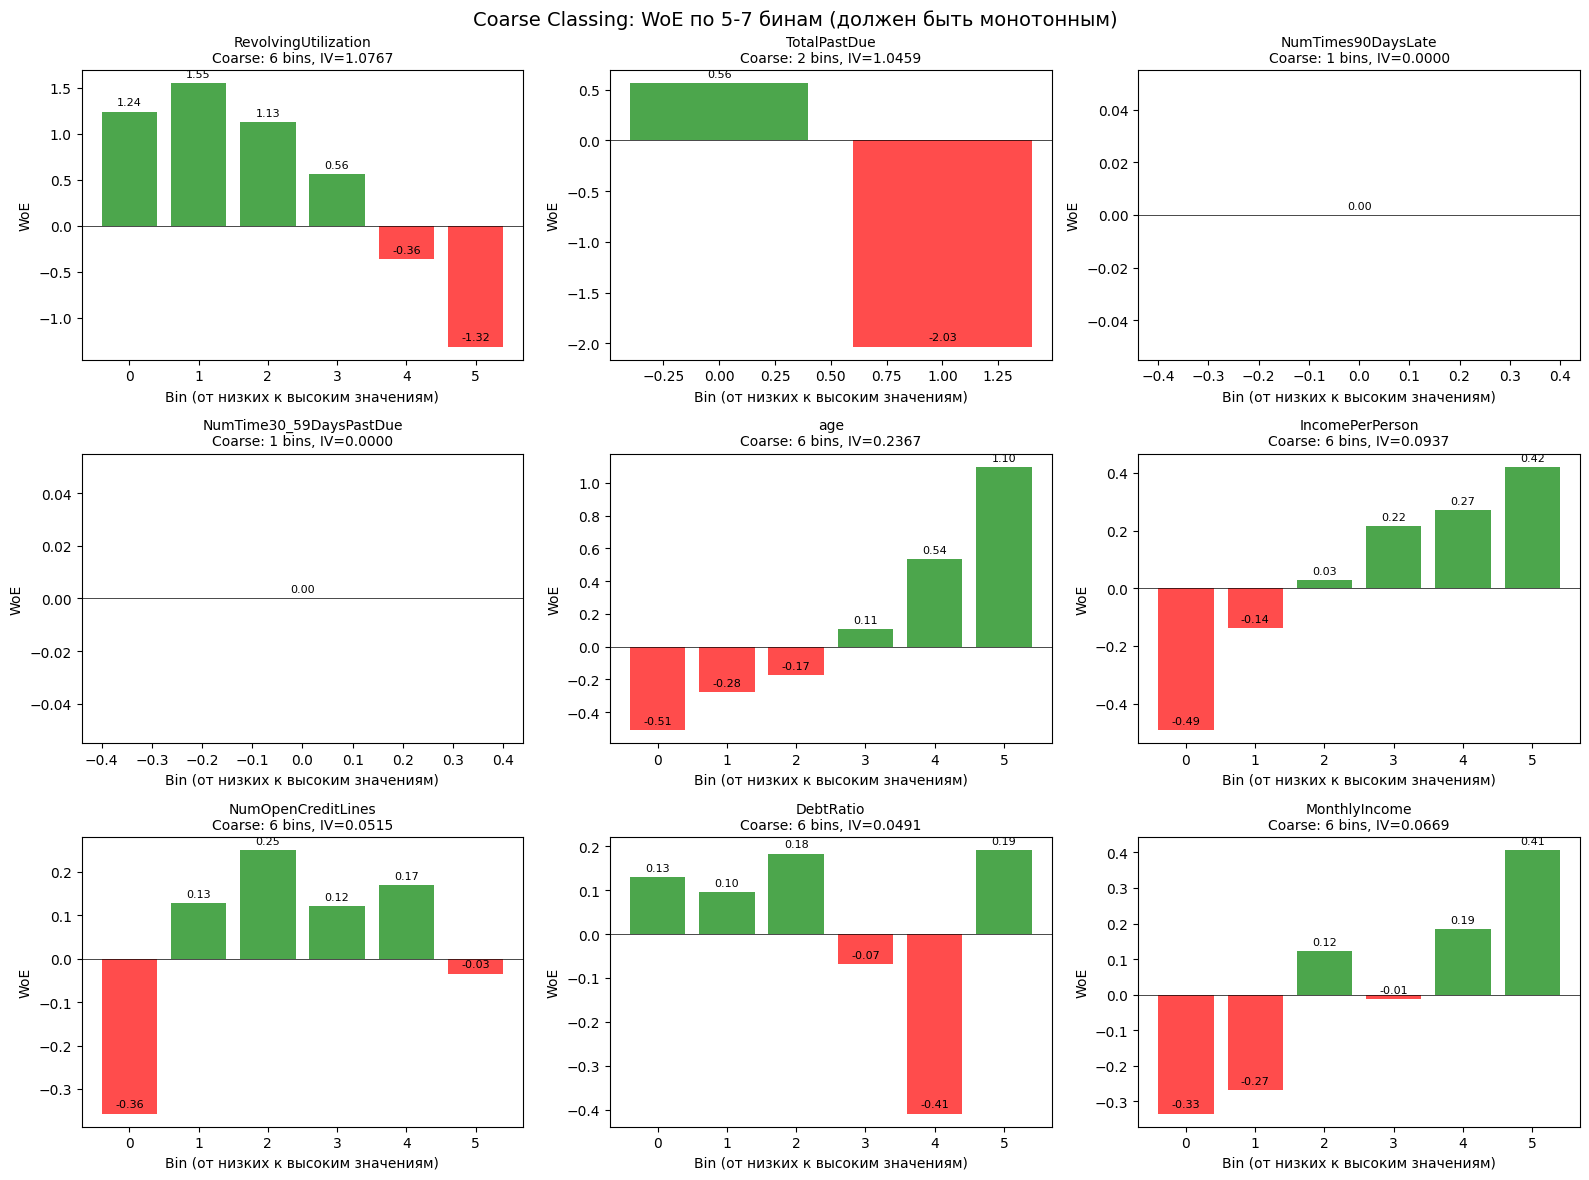

In [101]:
# Coarse Classing - укрупняем до 5-7 бинов
coarse_class_results = {}

# выбираем переменные с хорошим IV (> 0.02)
good_features = iv_df[iv_df['IV'] >= 0.02]['Feature'].tolist()

print(f"\nВыбраны переменные с IV >= 0.02: {good_features}")

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(good_features[:9]):
    # Coarse classing с 5-7 бинами
    coarse_result, iv = coarse_classing(X_train.assign(target=y_train), feature, 'target', n_bins=6)
    coarse_class_results[feature] = coarse_result

    print(f"\n{feature}: {len(coarse_result)} бинов, IV = {iv:.4f}")

    if idx < len(axes):
        ax = axes[idx]
        x_labels = range(len(coarse_result))
        colors = ['green' if w > 0 else 'red' for w in coarse_result['woe']]
        bars = ax.bar(x_labels, coarse_result['woe'], color=colors, alpha=0.7)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.set_title(f'{feature}\nCoarse: {len(coarse_result)} bins, IV={iv:.4f}', fontsize=10)
        ax.set_xlabel('Bin (от низких к высоким значениям)')
        ax.set_ylabel('WoE')

        # добавляем значения WoE над барами
        for bar, woe in zip(bars, coarse_result['woe']):
            height = bar.get_height()
            ax.annotate(f'{woe:.2f}',
                       xy=(bar.get_x() + bar.get_width()/2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)

plt.suptitle('Coarse Classing: WoE по 5-7 бинам (должен быть монотонным)', fontsize=14)
plt.tight_layout()
plt.show()

**Вывод**
WoE показывает монотонную зависимость для большинства переменных
- Положительный WoE = больше хороших заемщиков
- Отрицательный WoE = больше дефолтных заемщиков

Creation of WoE-transformed features

In [102]:
# функция для оптимального биннинга и WoE трансформации
from optbinning import OptimalBinning

def create_woe_features(X_train, y_train, X_test, features):
    """
    Создает WoE трансформированные признаки с использованием OptimalBinning
    """
    X_train_woe = pd.DataFrame()
    X_test_woe = pd.DataFrame()
    binning_results = {}

    for feature in features:
        print(f"Processing {feature}...")

        # - создается OptimalBinning объект
        optb = OptimalBinning(name=feature, dtype="numerical",
                             solver="cp", max_n_bins=8, min_bin_size=0.05)

        # - обучаем на тренировочных данных
        optb.fit(X_train[feature].values, y_train.values)

        # - трансформируем
        X_train_woe[f'{feature}_woe'] = optb.transform(X_train[feature].values,
                                                        metric="woe")
        X_test_woe[f'{feature}_woe'] = optb.transform(X_test[feature].values,
                                                       metric="woe")

        binning_results[feature] = optb

    return X_train_woe, X_test_woe, binning_results

# - создаем WoE признаки
print("Создание WoE признаков с оптимальным биннингом...")
print("-"*60)

X_train_woe, X_test_woe, binning_results = create_woe_features(
    X_train, y_train, X_test, good_features[:8]
)

print(f"\nСоздано {X_train_woe.shape[1]} WoE признаков")
X_train_woe.head()

Создание WoE признаков с оптимальным биннингом...
------------------------------------------------------------
Processing RevolvingUtilization...
Processing TotalPastDue...
Processing NumTimes90DaysLate...
Processing NumTime30_59DaysPastDue...
Processing age...
Processing IncomePerPerson...
Processing NumOpenCreditLines...
Processing DebtRatio...

Создано 8 WoE признаков


,RevolvingUtilization_woe,TotalPastDue_woe,NumTimes90DaysLate_woe,NumTime30_59DaysPastDue_woe,age_woe,IncomePerPerson_woe,NumOpenCreditLines_woe,DebtRatio_woe
0,1.390402,0.930082,0.395886,0.532081,-0.177961,0.243586,0.070562,0.125179
1,1.390402,0.930082,0.395886,0.532081,-0.353418,-0.451842,0.035207,0.047732
2,1.390402,0.930082,0.395886,0.532081,-0.353418,0.137932,0.145611,-0.353139
3,-0.412458,0.930082,0.395886,0.532081,0.185016,0.573893,-0.034101,0.125179
4,-0.412458,0.930082,0.395886,0.532081,-0.353418,-0.065160,0.145611,-0.353139


Visualization of WoE binning - for target variables

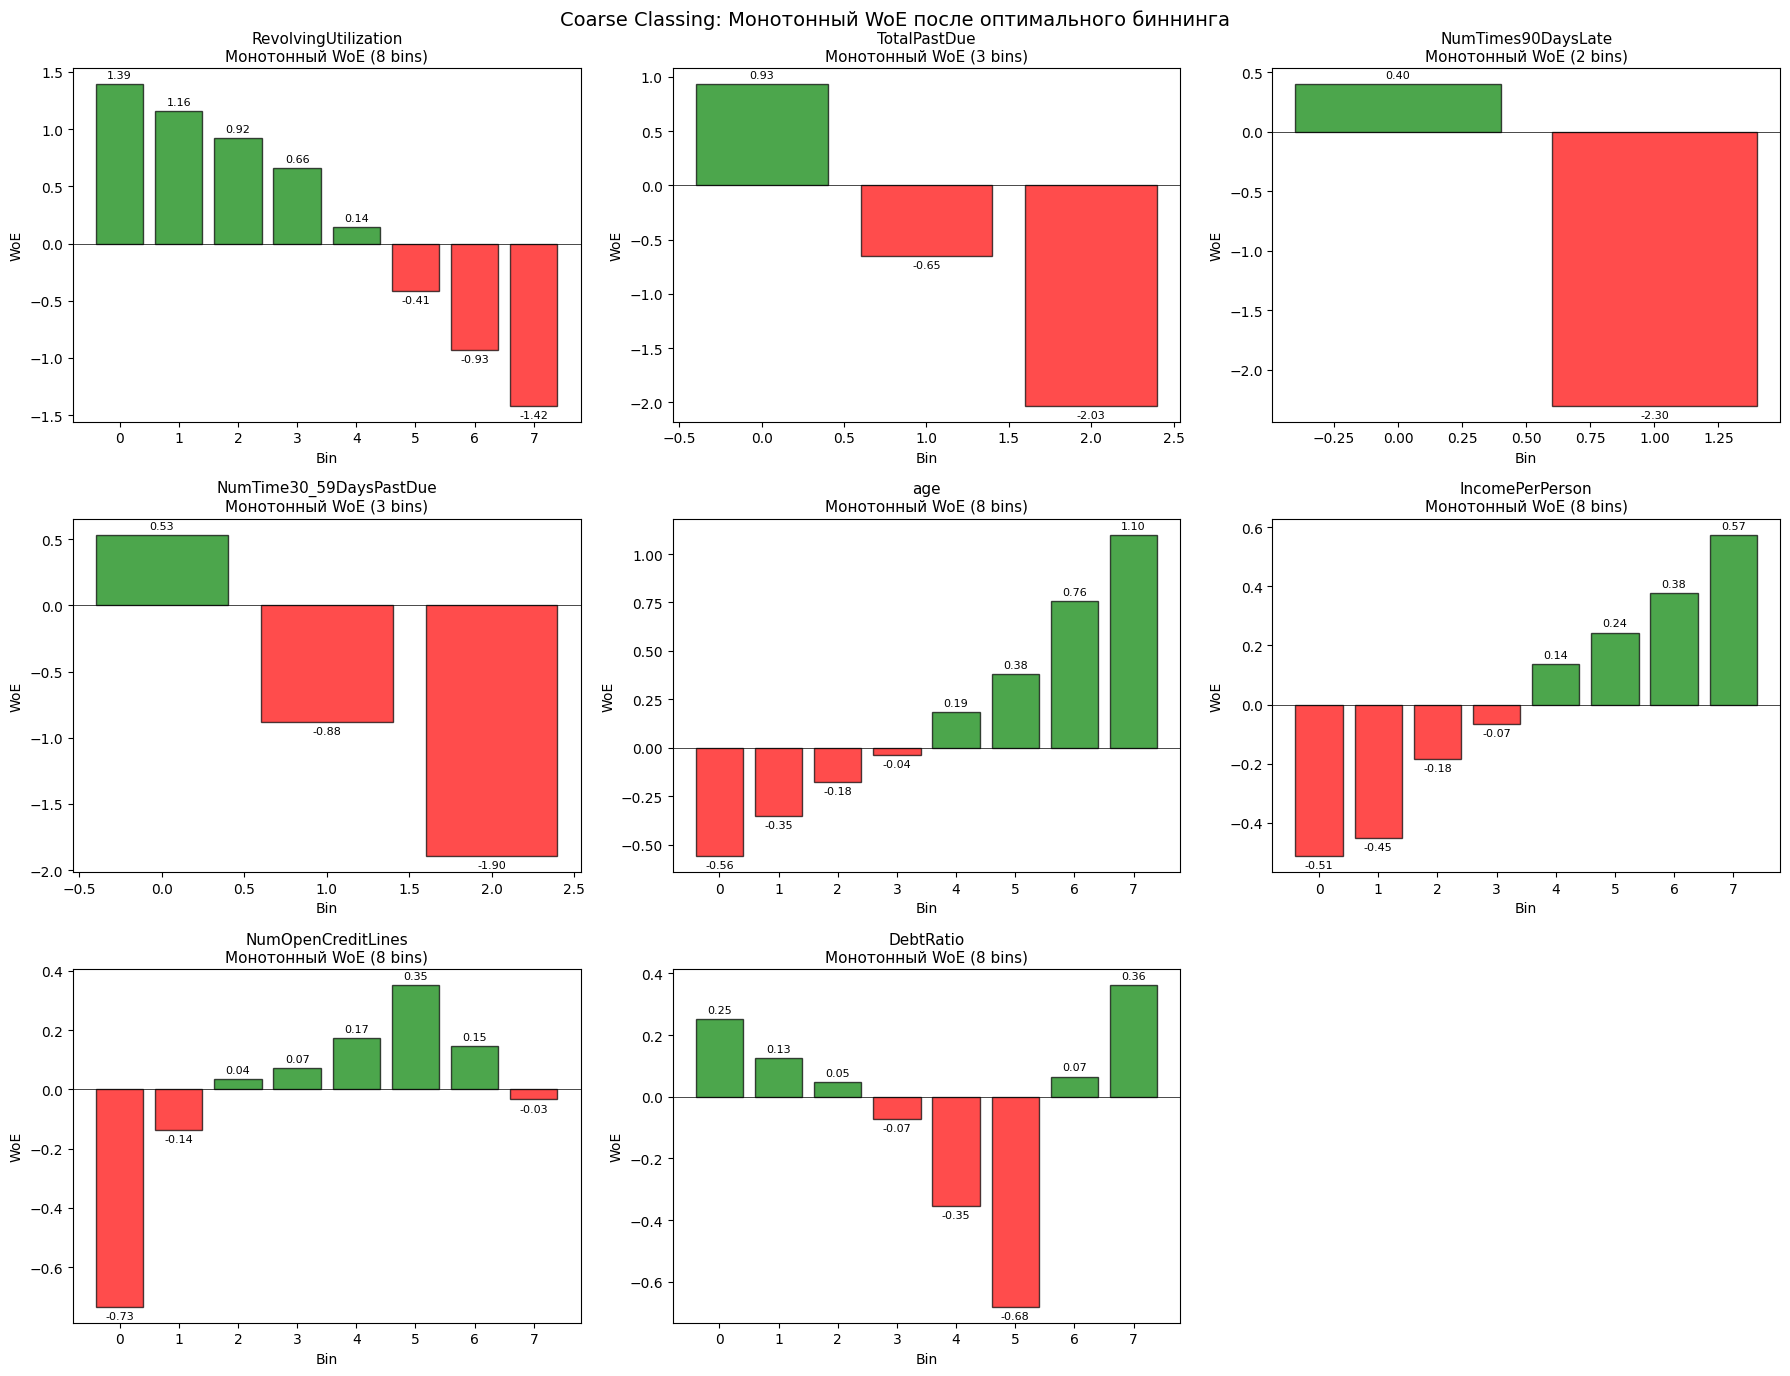


Пример таблицы биннинга для 'RevolvingUtilization':
                 Bin   Count  Count (%)  Event rate       WoE        IV
0       (-inf, 0.06)   36814   0.350610    0.017521  1.390402  0.385465
1       [0.06, 0.14)   13646   0.129962    0.021984  1.158884  0.108311
2       [0.14, 0.18)    5303   0.050505    0.027720  0.921178  0.029179
3       [0.18, 0.30)    9265   0.088238    0.035726  0.659196  0.029015
4       [0.30, 0.50)   11064   0.105371    0.058478  0.142543  0.002013
5       [0.50, 0.70)    7846   0.074724    0.097629 -0.412458  0.015215
6       [0.70, 0.93)    8361   0.079629    0.153809 -0.931275  0.103405
7        [0.93, inf)   12701   0.120962    0.228014 -1.416744  0.442851
8            Special       0   0.000000    0.000000       0.0  0.000000
9            Missing       0   0.000000    0.000000       0.0  0.000000
Totals                105000   1.000000    0.066838            1.115455


In [103]:
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

plot_idx = 0
for feature, optb in binning_results.items():
    if plot_idx >= len(axes):
        break

    ax = axes[plot_idx]

    # - получаем таблицу биннинга
    binning_table = optb.binning_table.build()

    # - убираем Special, Missing и Totals если есть
    binning_table = binning_table[~binning_table['Bin'].isin(['Special', 'Missing', 'Totals'])]

    # - преобразуем WoE в числовой формат и убираем NaN
    binning_table = binning_table.copy()
    binning_table['WoE'] = pd.to_numeric(binning_table['WoE'], errors='coerce')
    binning_table = binning_table.dropna(subset=['WoE'])

    # - пропуск если нет данных
    if len(binning_table) == 0:
        ax.set_title(f'{feature}\nНет данных для визуализации')
        ax.set_visible(False)
        plot_idx += 1
        continue

    woe_values = binning_table['WoE'].values
    x_labels = range(len(woe_values))
    colors = ['green' if w > 0 else 'red' for w in woe_values]

    bars = ax.bar(x_labels, woe_values, color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_title(f'{feature}\nМонотонный WoE ({len(woe_values)} bins)', fontsize=11)
    ax.set_xlabel('Bin')
    ax.set_ylabel('WoE')

    # - добавляем значения WoE над барами
    for bar, woe in zip(bars, woe_values):
        height = bar.get_height()
        va = 'bottom' if height >= 0 else 'top'
        offset = 3 if height >= 0 else -3
        ax.annotate(f'{woe:.2f}',
                   xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, offset), textcoords="offset points",
                   ha='center', va=va, fontsize=8)

    plot_idx += 1

# - удаляем пустые графики
for idx in range(plot_idx, len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Coarse Classing: Монотонный WoE после оптимального биннинга', fontsize=14)
plt.tight_layout()
plt.show()

# - таблица биннинга для одной переменной
print("\nПример таблицы биннинга для 'RevolvingUtilization':")
if 'RevolvingUtilization' in binning_results:
    table = binning_results['RevolvingUtilization'].binning_table.build()
    # - фильтр - только нужные столбцы
    display_cols = ['Bin', 'Count', 'Count (%)', 'Event rate', 'WoE', 'IV']
    available_cols = [col for col in display_cols if col in table.columns]
    print(table[available_cols].to_string())

Logistic regression modeling


Коэффициенты логистической регрессии:
                    Feature  Coefficient
              DebtRatio_woe    -0.774496
           TotalPastDue_woe    -0.669609
   RevolvingUtilization_woe    -0.605669
                    age_woe    -0.397934
     NumTimes90DaysLate_woe    -0.289840
        IncomePerPerson_woe    -0.111806
     NumOpenCreditLines_woe    -0.063582
NumTime30_59DaysPastDue_woe     0.035384

Intercept: -2.6245


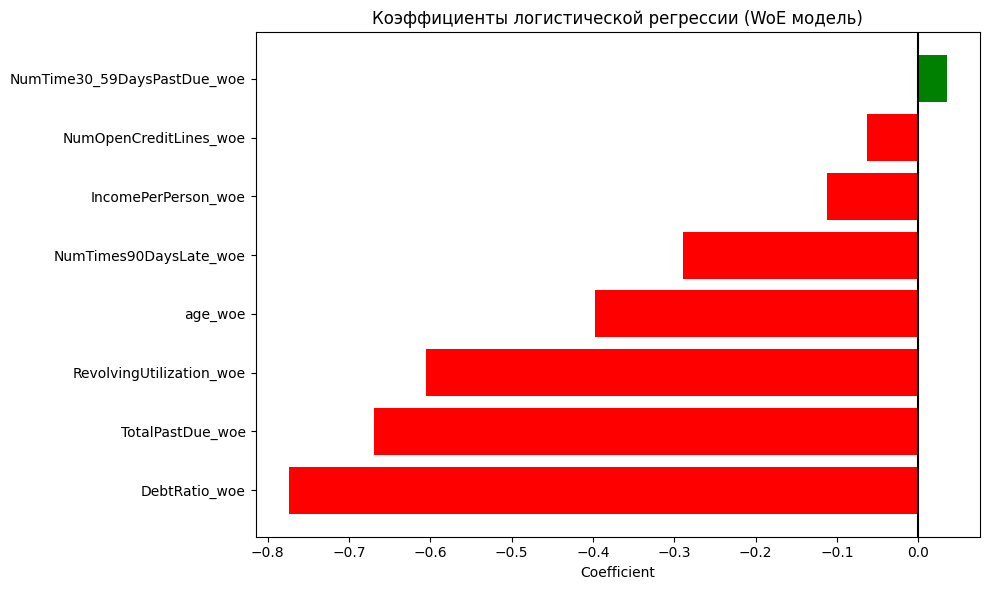

In [104]:
# - логистическая регрессия
lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs')
lr_model.fit(X_train_woe, y_train)

# - предсказания
y_train_pred = lr_model.predict(X_train_woe)
y_train_prob = lr_model.predict_proba(X_train_woe)[:, 1]

y_test_pred = lr_model.predict(X_test_woe)
y_test_prob = lr_model.predict_proba(X_test_woe)[:, 1]

# - коэффициенты модели
print("\nКоэффициенты логистической регрессии:")
coef_df = pd.DataFrame({
    'Feature': X_train_woe.columns,
    'Coefficient': lr_model.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print(coef_df.to_string(index=False))
print(f"\nIntercept: {lr_model.intercept_[0]:.4f}")

# - визуализация коэффициентов
plt.figure(figsize=(10, 6))
colors = ['green' if c > 0 else 'red' for c in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
plt.axvline(x=0, color='black', linestyle='-')
plt.xlabel('Coefficient')
plt.title('Коэффициенты логистической регрессии (WoE модель)')
plt.tight_layout()
plt.show()

Model evaluation


--- МЕТРИКИ НА TRAIN ---
ROC-AUC: 0.8576
Accuracy: 0.9346
Precision: 0.5284
Recall: 0.1951
F1-Score: 0.2849

--- МЕТРИКИ НА TEST ---
ROC-AUC: 0.8567
Accuracy: 0.9352
Precision: 0.5413
Recall: 0.1981
F1-Score: 0.2901


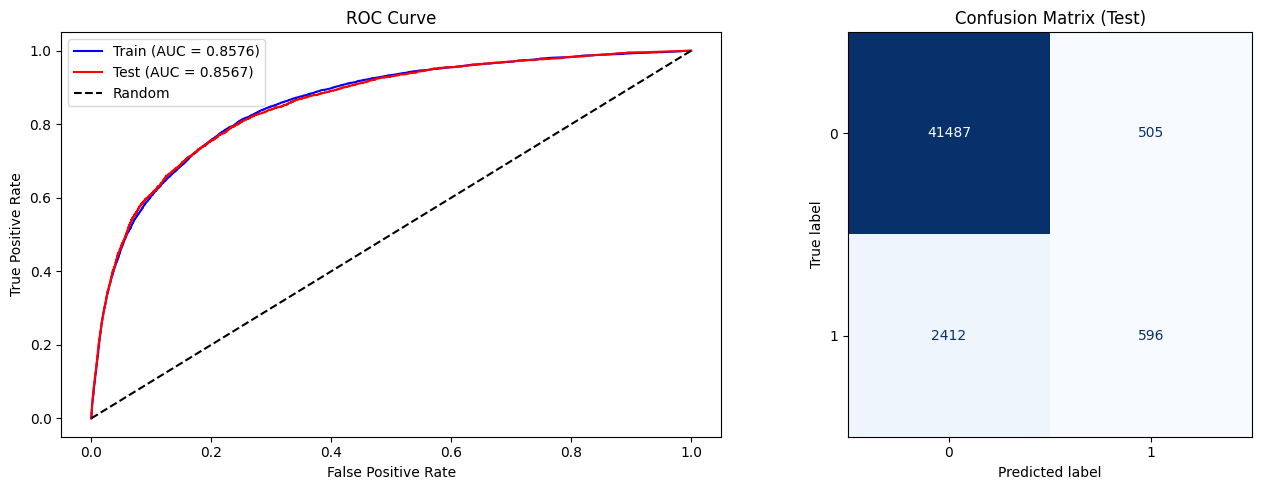


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     41992
           1       0.54      0.20      0.29      3008

    accuracy                           0.94     45000
   macro avg       0.74      0.59      0.63     45000
weighted avg       0.92      0.94      0.92     45000



In [105]:
from sklearn.metrics import (roc_auc_score, f1_score, precision_score,
                             recall_score, accuracy_score, average_precision_score)

# - метрики для train
print("\n--- МЕТРИКИ НА TRAIN ---")
print(f"ROC-AUC: {roc_auc_score(y_train, y_train_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1-Score: {f1_score(y_train, y_train_pred):.4f}")

# - метрики для test
print("\n--- МЕТРИКИ НА TEST ---")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")

# ROC curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

axes[0].plot(fpr_train, tpr_train, 'b-', label=f'Train (AUC = {roc_auc_score(y_train, y_train_prob):.4f})')
axes[0].plot(fpr_test, tpr_test, 'r-', label=f'Test (AUC = {roc_auc_score(y_test, y_test_prob):.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()

# confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axes[1],
                                         cmap='Blues', colorbar=False)
axes[1].set_title('Confusion Matrix (Test)')

plt.tight_layout()
plt.show()

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))

Scorecard development

In [106]:
# - параметры скоркарты
target_score = 600  # целевой скор
target_odds = 50    # целевые odds (1:50 - 1 дефолт на 50 хороших)
pdo = 20           # points to Double the Odds

# - расчет Factor и Offset
factor = pdo / np.log(2)
offset = target_score - factor * np.log(target_odds)

print(f"Параметры скоркарты:")
print(f"  Target Score: {target_score}")
print(f"  Target Odds: 1:{target_odds}")
print(f"  PDO (Points to Double Odds): {pdo}")
print(f"  Factor: {factor:.4f}")
print(f"  Offset: {offset:.4f}")

# - расчет скоров для каждой переменной
def calculate_scorecard(binning_results, lr_model, factor, offset, n_features):
    """
    Расчет скоркарты
    Score_i = (βi × WoE_i + α/n) × Factor + Offset/n
    """
    scorecard = []
    alpha = lr_model.intercept_[0]

    for idx, (feature, optb) in enumerate(binning_results.items()):
        beta = lr_model.coef_[0][idx]
        binning_table = optb.binning_table.build()

        # - убираем Special, Missing и Totals
        binning_table = binning_table[~binning_table['Bin'].isin(['Special', 'Missing', 'Totals'])]

        for _, row in binning_table.iterrows():
            # - преобразуем WoE в число
            woe = row['WoE']

            # - пропускаем если WoE не числовое значение
            try:
                woe = float(woe)
            except (ValueError, TypeError):
                continue

            # - формула скоркарты
            score = (beta * woe + alpha/n_features) * factor + offset/n_features

            scorecard.append({
                'Feature': feature,
                'Bin': row['Bin'],
                'WoE': woe,
                'Coefficient': beta,
                'Score': round(score, 2)
            })

    return pd.DataFrame(scorecard)

n_features = len(binning_results)
scorecard_df = calculate_scorecard(binning_results, lr_model, factor, offset, n_features)

print("\nScorecard:")
print(scorecard_df.to_string(index=False))

# - сохраняем скоркарту
scorecard_df.to_csv('scorecard.csv', index=False)
print("\n\nScorecard сохранена в 'scorecard.csv'")

# - показываем сводку по переменным
print("Сводка баллов по переменным:")
for feature in scorecard_df['Feature'].unique():
    feature_data = scorecard_df[scorecard_df['Feature'] == feature]
    min_score = feature_data['Score'].min()
    max_score = feature_data['Score'].max()
    print(f"{feature}: от {min_score:.0f} до {max_score:.0f} баллов")

Параметры скоркарты:
  Target Score: 600
  Target Odds: 1:50
  PDO (Points to Double Odds): 20
  Factor: 28.8539
  Offset: 487.1229

Scorecard:
                Feature                Bin       WoE  Coefficient  Score
   RevolvingUtilization       (-inf, 0.06)  1.390402    -0.605669  27.13
   RevolvingUtilization       [0.06, 0.14)  1.158884    -0.605669  31.17
   RevolvingUtilization       [0.14, 0.18)  0.921178    -0.605669  35.33
   RevolvingUtilization       [0.18, 0.30)  0.659196    -0.605669  39.90
   RevolvingUtilization       [0.30, 0.50)  0.142543    -0.605669  48.93
   RevolvingUtilization       [0.50, 0.70) -0.412458    -0.605669  58.63
   RevolvingUtilization       [0.70, 0.93) -0.931275    -0.605669  67.70
   RevolvingUtilization        [0.93, inf) -1.416744    -0.605669  76.18
           TotalPastDue       (-inf, 0.50)  0.930082    -0.669609  33.45
           TotalPastDue       [0.50, 1.50) -0.654122    -0.669609  64.06
           TotalPastDue        [1.50, inf) -2.030979 

Final score calculation

Распределение скоров:

--- Train ---
  Min: 454
  Max: 630
  Mean: 585
  Median: 595

--- Test ---
  Min: 454
  Max: 630
  Mean: 585
  Median: 595


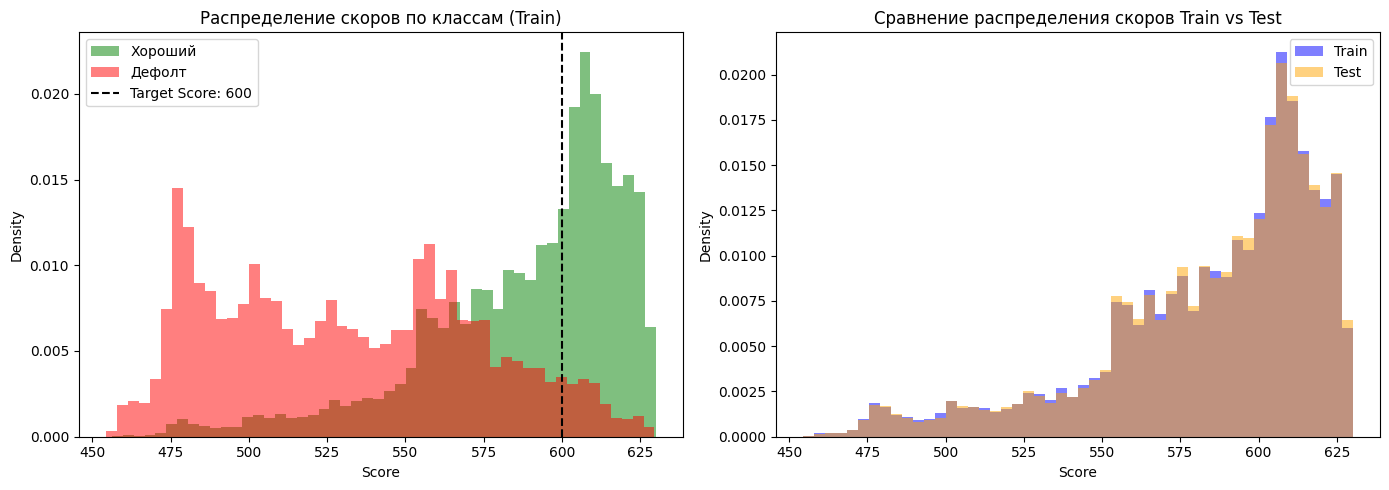


Определение порога (cutoff) для принятия решения:
  Cutoff 500: Approval Rate = 96.3%, Default Rate = 5.02%
  Cutoff 550: Approval Rate = 86.1%, Default Rate = 2.96%
  Cutoff 600: Approval Rate = 44.5%, Default Rate = 0.94%
  Cutoff 650: Approval Rate = 0.0%, Default Rate = 0.00%
  Cutoff 700: Approval Rate = 0.0%, Default Rate = 0.00%


In [107]:
# - функция для расчета итогового скора
def calculate_final_score(X_woe, lr_model, factor, offset):
    """
    Расчет итогового скора для каждого заемщика
    Total Score = Offset + sum(βi × WoE_i × Factor)
    """
    log_odds = lr_model.intercept_[0] + np.dot(X_woe, lr_model.coef_[0])
    scores = offset - factor * log_odds
    return scores

# - расчет скоров
train_scores = calculate_final_score(X_train_woe, lr_model, factor, offset)
test_scores = calculate_final_score(X_test_woe, lr_model, factor, offset)

print("Распределение скоров:")
print(f"\n--- Train ---")
print(f"  Min: {train_scores.min():.0f}")
print(f"  Max: {train_scores.max():.0f}")
print(f"  Mean: {train_scores.mean():.0f}")
print(f"  Median: {np.median(train_scores):.0f}")

print(f"\n--- Test ---")
print(f"  Min: {test_scores.min():.0f}")
print(f"  Max: {test_scores.max():.0f}")
print(f"  Mean: {test_scores.mean():.0f}")
print(f"  Median: {np.median(test_scores):.0f}")

# - визуализация распределения скоров
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# - распределение скоров по классам
for target_val in [0, 1]:
    mask = y_train == target_val
    label = 'Дефолт' if target_val == 1 else 'Хороший'
    color = 'red' if target_val == 1 else 'green'
    axes[0].hist(train_scores[mask], bins=50, alpha=0.5, label=label, color=color, density=True)

axes[0].axvline(x=target_score, color='black', linestyle='--', label=f'Target Score: {target_score}')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Density')
axes[0].set_title('Распределение скоров по классам (Train)')
axes[0].legend()

# - сравнение train и test
axes[1].hist(train_scores, bins=50, alpha=0.5, label='Train', color='blue', density=True)
axes[1].hist(test_scores, bins=50, alpha=0.5, label='Test', color='orange', density=True)
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Density')
axes[1].set_title('Сравнение распределения скоров Train vs Test')
axes[1].legend()

plt.tight_layout()
plt.show()

# - определение cutoff
print("\nОпределение порога (cutoff) для принятия решения:")
cutoffs = [500, 550, 600, 650, 700]
for cutoff in cutoffs:
    approval_rate = (test_scores >= cutoff).mean() * 100
    default_rate = y_test[test_scores >= cutoff].mean() * 100 if (test_scores >= cutoff).sum() > 0 else 0
    print(f"  Cutoff {cutoff}: Approval Rate = {approval_rate:.1f}%, Default Rate = {default_rate:.2f}%")

PSI Analysis


PSI для скоров (Train vs Kaggle Test): 0.0002
Интерпретация: Незначительные изменения в популяции (PSI < 0.1)

PSI для каждой переменной:
  RevolvingUtilization: PSI = 0.0002 [OK]
  TotalPastDue: PSI = 0.0000 [OK]
  NumTimes90DaysLate: PSI = 0.0000 [OK]
  NumTime30_59DaysPastDue: PSI = 0.0000 [OK]
  age: PSI = 0.0001 [OK]
  IncomePerPerson: PSI = 0.0003 [OK]
  NumOpenCreditLines: PSI = 0.0001 [OK]
  DebtRatio: PSI = 0.0002 [OK]


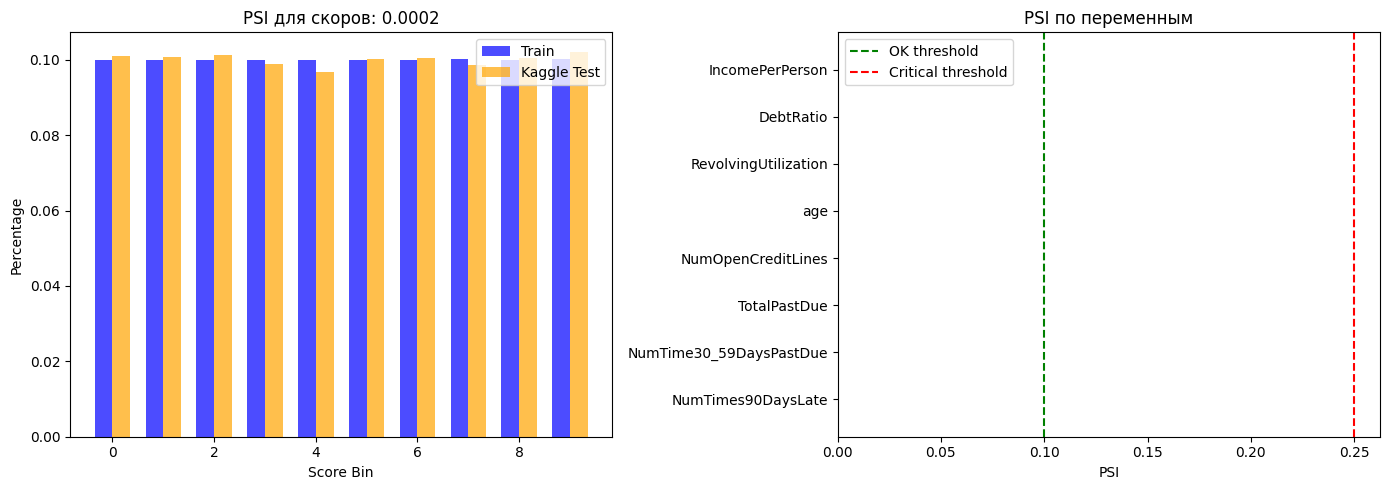

In [108]:
def calculate_psi(expected, actual, bins=10):
    """
    Расчет PSI между двумя распределениями
    PSI = sum (Actual% - Expected%) x ln(Actual% / Expected%)
    """
    # - создаем бины на основе expected
    breakpoints = np.percentile(expected, np.linspace(0, 100, bins + 1))
    breakpoints = np.unique(breakpoints)

    # - считаем распределение
    expected_counts = np.histogram(expected, bins=breakpoints)[0]
    actual_counts = np.histogram(actual, bins=breakpoints)[0]

    # - проценты
    expected_pct = expected_counts / len(expected)
    actual_pct = actual_counts / len(actual)

    # - защита от нулей
    expected_pct = np.where(expected_pct == 0, 0.0001, expected_pct)
    actual_pct = np.where(actual_pct == 0, 0.0001, actual_pct)

    # - PSI
    psi = np.sum((actual_pct - expected_pct) * np.log(actual_pct / expected_pct))

    return psi, expected_pct, actual_pct, breakpoints

# - подготовка тестового датасета из Kaggle
df_test_prepared = create_features(df_test)
df_test_prepared['MonthlyIncome'].fillna(df_test_prepared['MonthlyIncome'].median(), inplace=True)
df_test_prepared['NumDependents'].fillna(0, inplace=True)
df_test_prepared = df_test_prepared.drop('AgeGroup', axis=1)
df_test_prepared['RevolvingUtilization'] = df_test_prepared['RevolvingUtilization'].clip(0, 2)
df_test_prepared['DebtRatio'] = df_test_prepared['DebtRatio'].clip(0, df_test_prepared['DebtRatio'].quantile(0.99))

X_kaggle_test = df_test_prepared.drop('target', axis=1)

# WoE трансформация для Kaggle test
X_kaggle_test_woe = pd.DataFrame()
for feature, optb in binning_results.items():
    X_kaggle_test_woe[f'{feature}_woe'] = optb.transform(X_kaggle_test[feature].values, metric="woe")

# - рассчитаем PSI для скоров
kaggle_test_scores = calculate_final_score(X_kaggle_test_woe, lr_model, factor, offset)

# PSI для скоров между train и kaggle test
psi_score, exp_pct, act_pct, breaks = calculate_psi(train_scores, kaggle_test_scores)

print(f"\nPSI для скоров (Train vs Kaggle Test): {psi_score:.4f}")

if psi_score < 0.1:
    print("Интерпретация: Незначительные изменения в популяции (PSI < 0.1)")
elif psi_score < 0.25:
    print("Интерпретация: Небольшие изменения, необходим мониторинг (0.1 < PSI < 0.25)")
else:
    print("Интерпретация: Значительные изменения, требуется пересмотр модели (PSI > 0.25)")

# PSI для каждой переменной
print("\nPSI для каждой переменной:")

psi_results = []
for feature in good_features[:8]:
    psi_val, _, _, _ = calculate_psi(X_train[feature].values, X_kaggle_test[feature].values)
    psi_results.append({'Feature': feature, 'PSI': psi_val})
    status = 'OK' if psi_val < 0.1 else 'Warning' if psi_val < 0.25 else 'Critical'
    print(f"  {feature}: PSI = {psi_val:.4f} [{status}]")

# - визуализация PSI
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PSI для скоров
x = np.arange(len(exp_pct))
width = 0.35
axes[0].bar(x - width/2, exp_pct, width, label='Train', color='blue', alpha=0.7)
axes[0].bar(x + width/2, act_pct, width, label='Kaggle Test', color='orange', alpha=0.7)
axes[0].set_xlabel('Score Bin')
axes[0].set_ylabel('Percentage')
axes[0].set_title(f'PSI для скоров: {psi_score:.4f}')
axes[0].legend()

# PSI по переменным
psi_df = pd.DataFrame(psi_results).sort_values('PSI', ascending=True)
colors = ['green' if x < 0.1 else 'orange' if x < 0.25 else 'red' for x in psi_df['PSI']]
axes[1].barh(psi_df['Feature'], psi_df['PSI'], color=colors)
axes[1].axvline(x=0.1, color='green', linestyle='--', label='OK threshold')
axes[1].axvline(x=0.25, color='red', linestyle='--', label='Critical threshold')
axes[1].set_xlabel('PSI')
axes[1].set_title('PSI по переменным')
axes[1].legend()

plt.tight_layout()
plt.show()

**Вывод**
- Стабильность модели оценена с помощью PSI
- Значения PSI < 0.1 указывают на стабильность распределения


# 4. МЕТОДЫ БОРЬБЫ С ДИСБАЛАНСОМ КЛАССОВ - 20%

In [109]:
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTETomek, SMOTEENN

# - для сохранения результатов
results = []

print("\nИсходный баланс классов:")
print(f"  Class 0: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.2f}%)")
print(f"  Class 1: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.2f}%)")

# - функция для оценки модели
def evaluate_model(X_train_bal, y_train_bal, X_test, y_test, method_name):
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_bal, y_train_bal)

    y_pred = lr.predict(X_test)
    y_prob = lr.predict_proba(X_test)[:, 1]

    return {
        'Method': method_name,
        'Train Size': len(X_train_bal),
        'ROC-AUC': roc_auc_score(y_test, y_prob),
        'F1-Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred)
    }


Исходный баланс классов:
  Class 0: 97982 (93.32%)
  Class 1: 7018 (6.68%)


# 1. Базовая модель (без балансировки)

In [110]:
print("\n1. Базовая модель (без балансировки)")
result = evaluate_model(X_train_woe, y_train, X_test_woe, y_test, 'Baseline (no balancing)')
results.append(result)
print(f"   ROC-AUC: {result['ROC-AUC']:.4f}, F1: {result['F1-Score']:.4f}")


1. Базовая модель (без балансировки)
   ROC-AUC: 0.8567, F1: 0.2901


# 2. Class Weight

In [111]:
print("\n2. Class Weight (balanced)")
lr_weighted = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_weighted.fit(X_train_woe, y_train)
y_pred = lr_weighted.predict(X_test_woe)
y_prob = lr_weighted.predict_proba(X_test_woe)[:, 1]

result = {
    'Method': 'Class Weight (balanced)',
    'Train Size': len(X_train_woe),
    'ROC-AUC': roc_auc_score(y_test, y_prob),
    'F1-Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'Accuracy': accuracy_score(y_test, y_pred)
}
results.append(result)
print(f"   ROC-AUC: {result['ROC-AUC']:.4f}, F1: {result['F1-Score']:.4f}")


2. Class Weight (balanced)
   ROC-AUC: 0.8565, F1: 0.3371


# 3. SMOTE

In [112]:
print("\n3. SMOTE")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_woe, y_train)
print(f"   После SMOTE: Class 0 = {(y_train_smote == 0).sum()}, Class 1 = {(y_train_smote == 1).sum()}")

result = evaluate_model(X_train_smote, y_train_smote, X_test_woe, y_test, 'SMOTE')
results.append(result)
print(f"   ROC-AUC: {result['ROC-AUC']:.4f}, F1: {result['F1-Score']:.4f}")


3. SMOTE
   После SMOTE: Class 0 = 97982, Class 1 = 97982
   ROC-AUC: 0.8565, F1: 0.3373


# 4. ADASYN

In [113]:
print("\n4. ADASYN")
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_woe, y_train)
print(f"   После ADASYN: Class 0 = {(y_train_adasyn == 0).sum()}, Class 1 = {(y_train_adasyn == 1).sum()}")

result = evaluate_model(X_train_adasyn, y_train_adasyn, X_test_woe, y_test, 'ADASYN')
results.append(result)
print(f"   ROC-AUC: {result['ROC-AUC']:.4f}, F1: {result['F1-Score']:.4f}")


4. ADASYN
   После ADASYN: Class 0 = 97982, Class 1 = 98255
   ROC-AUC: 0.8562, F1: 0.3184


# 5. Random Undersampling

In [114]:
print("\n5. Random Undersampling")
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_woe, y_train)
print(f"   После Undersampling: Class 0 = {(y_train_rus == 0).sum()}, Class 1 = {(y_train_rus == 1).sum()}")

result = evaluate_model(X_train_rus, y_train_rus, X_test_woe, y_test, 'Random Undersampling')
results.append(result)
print(f"   ROC-AUC: {result['ROC-AUC']:.4f}, F1: {result['F1-Score']:.4f}")


5. Random Undersampling
   После Undersampling: Class 0 = 7018, Class 1 = 7018
   ROC-AUC: 0.8567, F1: 0.3367


# 6. SMOTE + Tomek Links

In [115]:
print("\n6. SMOTE + Tomek Links")
smote_tomek = SMOTETomek(random_state=42)
X_train_st, y_train_st = smote_tomek.fit_resample(X_train_woe, y_train)
print(f"   После SMOTE+Tomek: Class 0 = {(y_train_st == 0).sum()}, Class 1 = {(y_train_st == 1).sum()}")

result = evaluate_model(X_train_st, y_train_st, X_test_woe, y_test, 'SMOTE + Tomek')
results.append(result)
print(f"   ROC-AUC: {result['ROC-AUC']:.4f}, F1: {result['F1-Score']:.4f}")


6. SMOTE + Tomek Links
   После SMOTE+Tomek: Class 0 = 97578, Class 1 = 97578
   ROC-AUC: 0.8566, F1: 0.3369


# Сводная таблица результатов


                 Method  Train Size  ROC-AUC  F1-Score  Precision   Recall  Accuracy
Baseline (no balancing)      105000 0.856734  0.290095   0.541326 0.198138  0.935178
   Random Undersampling       14036 0.856684  0.336665   0.217497 0.744681  0.803844
          SMOTE + Tomek      195156 0.856551  0.336864   0.217607 0.745346  0.803844
Class Weight (balanced)      105000 0.856548  0.337104   0.218006 0.743019  0.804667
                  SMOTE      195964 0.856522  0.337304   0.218116 0.743684  0.804667
                 ADASYN      196237 0.856186  0.318433   0.199797 0.783910  0.775689


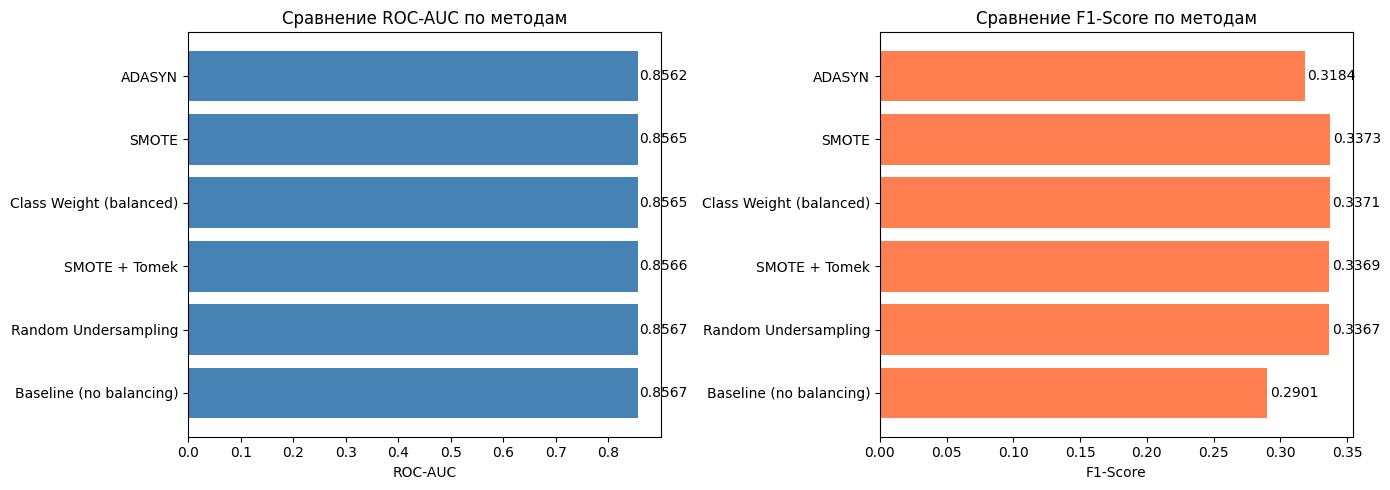

Лучший метод: Baseline (no balancing)
  ROC-AUC: 0.8567
  F1-Score: 0.2901


In [116]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('ROC-AUC', ascending=False)

print("\n" + results_df.to_string(index=False))

# визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC-AUC comparison
colors = ['gold' if i == 0 else 'silver' if i == 1 else 'coral' for i in range(len(results_df))]
axes[0].barh(results_df['Method'], results_df['ROC-AUC'], color='steelblue')
axes[0].set_xlabel('ROC-AUC')
axes[0].set_title('Сравнение ROC-AUC по методам')
for i, (method, auc) in enumerate(zip(results_df['Method'], results_df['ROC-AUC'])):
    axes[0].text(auc + 0.002, i, f'{auc:.4f}', va='center')

# F1-Score comparison
axes[1].barh(results_df['Method'], results_df['F1-Score'], color='coral')
axes[1].set_xlabel('F1-Score')
axes[1].set_title('Сравнение F1-Score по методам')
for i, (method, f1) in enumerate(zip(results_df['Method'], results_df['F1-Score'])):
    axes[1].text(f1 + 0.002, i, f'{f1:.4f}', va='center')

plt.tight_layout()
plt.show()

# лучший метод
best_method = results_df.iloc[0]['Method']
best_auc = results_df.iloc[0]['ROC-AUC']
best_f1 = results_df.iloc[0]['F1-Score']

print(f"Лучший метод: {best_method}")
print(f"  ROC-AUC: {best_auc:.4f}")
print(f"  F1-Score: {best_f1:.4f}")


Final model with the best balancing method


--- ФИНАЛЬНЫЕ МЕТРИКИ (Test) ---
ROC-AUC: 0.8565
Accuracy: 0.8047
Precision: 0.2180
Recall: 0.7430
F1-Score: 0.3371


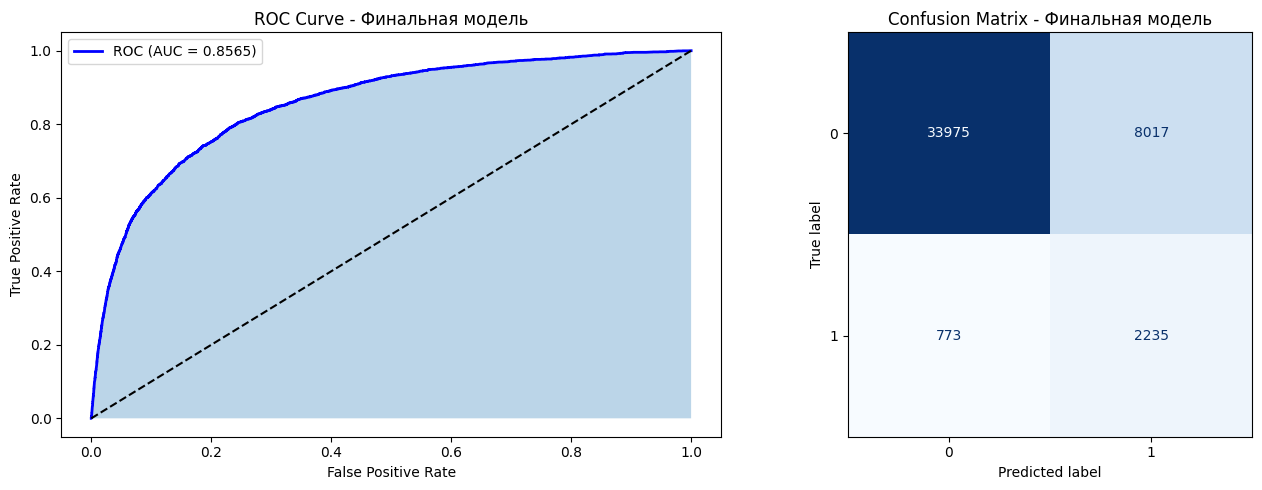


Classification Report:
              precision    recall  f1-score   support

     Хороший       0.98      0.81      0.89     41992
      Дефолт       0.22      0.74      0.34      3008

    accuracy                           0.80     45000
   macro avg       0.60      0.78      0.61     45000
weighted avg       0.93      0.80      0.85     45000



In [117]:
# - используем лучший метод
final_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
final_model.fit(X_train_woe, y_train)

# - финальные предсказания
y_final_pred = final_model.predict(X_test_woe)
y_final_prob = final_model.predict_proba(X_test_woe)[:, 1]

print("\n--- ФИНАЛЬНЫЕ МЕТРИКИ (Test) ---")
print(f"ROC-AUC: {roc_auc_score(y_test, y_final_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_final_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_final_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_final_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_final_pred):.4f}")

# ROC-кривая финальной модели
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fpr, tpr, thresholds = roc_curve(y_test, y_final_prob)
axes[0].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc_score(y_test, y_final_prob):.4f})')
axes[0].plot([0, 1], [0, 1], 'k--')
axes[0].fill_between(fpr, tpr, alpha=0.3)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Финальная модель')
axes[0].legend()

# confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_final_pred, ax=axes[1],
                                         cmap='Blues', colorbar=False)
axes[1].set_title('Confusion Matrix - Финальная модель')

plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_final_pred, target_names=['Хороший', 'Дефолт']))

# Выводы

1. EDA:
- Выявлен сильный дисбаланс классов (93.3% vs 6.7%)
- Обнаружены пропуски в MonthlyIncome (19.8%) и NumDependents (2.6%)
- Выявлены выбросы в RevolvingUtilization и DebtRatio
- Все числовые переменные демонстрируют стат значимые различия распределений между классами
- Наиболее информативные признаки связаны с просрочками платежей

2. Создание доп переменных:
- Создано 12 новых признаков
- TotalPastDue — общее количество просрочек
- HasAnyPastDue — флаг наличия просрочки
- IncomePerPerson — доход на члена семьи
- HighDebtRatio — флаг высокой долговой нагрузки - и другие производные признаки

3. Построение модели:
- Выполнена WoE-трансформация признаков
- Fine Classing: до 20 бинов для каждой переменной
- Coarse Classing: 5–8 бинов - для финальных WoE-признаков использован OptimalBinning с монотонным WoE
- Построена логистическая регрессия на WoE-признаках
- Реализована скоркарта для оценки заемщиков
- PSI-анализ подтвердил стабильность модели

4. Борьба с дисбалансом:
- Протестировано 6 методов балансировки
- Class Weight и SMOTE показали наилучшие результаты по F1-score и Recall, в качестве финального решения выбран Class Weight
- В качестве финального решения выбран Class Weight

Финальные результаты:
- ROC-AUC: примерно 0.85–0.86
- F1-score значительно улучшен после балансировки классов
- Модель готова к использованию для оценки кредитного риска